# Question 3: Python Programming [10 marks] 

Study “Open Data on COVID-19 in Malaysia” by the Ministry of Health (MOH), Malaysia via https://github.com/MoH-Malaysia/covid19-public. Use only datasets from the categories “Cases and Testing”, “Healthcare”, “Deaths”, and “Static
data” for this assignment.

Answer the following questions and prepare your findings using the “Streamlit” package. Upload it Heroku.com. Each analysis must have at least one chart and a short paragraph explaining your findings.

## Questions
(i) Discuss the exploratory data analysis steps you have conducted including detection of outliers and missing values?

(ii) What are the states that exhibit strong correlation with (i) Pahang, and (ii) Johor?

(iii) What are the strong features/indicators to daily cases for (i) Pahang, (ii) Kedah, (iii) Johor, and (iv) Selangor? [Note: you must use at least 2 methods to justify your findings]

(iv) Comparing regression and classification models, what model performs well in predicting the daily cases for (i) Pahang, (ii) Kedah, (iii) Johor, and (iv) Selangor? Requirements:

1. Use TWO(2) regression models and TWO(2) classification models
2. Use appropriate evaluation metrics.

<span style='color:green'>Data taken from MoH Malaysia as of [`11-09-2021`](https://github.com/MoH-Malaysia/covid19-public/commit/a9d2a11512d0943db02140a03486f6862df87107)</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from collections import Counter

## 1. Simple Data Exploratory Analysis

In [2]:
# Loading the datasets

# cases and testing
cases_malaysia = pd.read_csv('dataset/cases_and_testing/cases_malaysia.csv')
cases_state = pd.read_csv('dataset/cases_and_testing/cases_state.csv') #
clusters = pd.read_csv('dataset/cases_and_testing/clusters.csv')
tests_malaysia = pd.read_csv('dataset/cases_and_testing/tests_malaysia.csv') 
tests_state = pd.read_csv('dataset/cases_and_testing/tests_state.csv') #

# deaths
deaths_malaysia = pd.read_csv('dataset/deaths/deaths_malaysia.csv')
deaths_state = pd.read_csv('dataset/deaths/deaths_state.csv') #

# healthcare
hospital = pd.read_csv('dataset/healthcare/hospital.csv')
icu = pd.read_csv('dataset/healthcare/icu.csv')
pkrc = pd.read_csv('dataset/healthcare/pkrc.csv')

# static data
population = pd.read_csv('dataset/static_data/population.csv')

It is found that multiple datasets have different start date (date of first record) and end date (date of last record).

| Dataset         | Start date | End date   | Number of rows |
| --------------- | ---------- | ---------- | -------------- |
| cases_malaysia  | 2020-01-25 | 2021-09-11 | 596            |
| cases_state     | 2020-01-25 | 2021-09-11 | 9536           |
| clusters        | 2020-03-01 | 2021-09-09 | 5022           |
| tests_malaysia  | 2020-01-24 | 2021-09-08 | 594            |
| tests_state     | 2021-07-01 | 2021-09-08 | 1120           |
| deaths_malaysia | 2020-03-17 | 2021-09-11 | 544            |
| deaths_state    | 2020-03-17 | 2021-09-11 | 8704           |
| hospital        | 2020-03-24 | 2021-09-11 | 8179           |
| icu             | 2020-03-24 | 2021-09-11 | 8179           |
| pkrc            | 2020-03-28 | 2021-09-11 | 6185           |
| population      | -          | -          | 17             |

Some useful functions for data exploratory.

In [3]:
# add a 'month' column by using 'date'
def add_month(df):
    df['month'] = df['date'].str[:-3]
    return df

# group data by months and count
def count_by_months(df):
    count_df = df.groupby(['month']).count()
    count_df.reset_index(inplace = True)
    return count_df

# group data by months and get mean
def avg_by_months(df):
    avg_df = df.groupby(['month']).mean()
    avg_df.reset_index(inplace = True)
    return avg_df

### 1.1 Cases and Testing

1. `date`: yyyy-mm-dd format; data correct as of 1200hrs on that date
2. `state`: name of state (present in state file, but not country file)
3. `cases_new`: cases reported in the 24h since the last report (except for 16th March 2020, for which the data is cumulative)
4. `cluster_x`: cases attributable to clusters under category `x`; possible values for `x` are import, religious, community, highRisk, education, detentionCentre, and workplace; the difference between `cases_new` and the sum of cases attributable to clusters is the number of sporadic cases.
5. `rtk-ag`: number of tests done using Antigen Rapid Test Kits (RTK-Ag)
6. `pcr`: number of tests done using Real-time Reverse Transcription Polymerase Chain Reaction (RT-PCR) technology

#### 1.1.1 cases_malaysia.csv

Daily recorded COVID-19 cases at country level.

In [4]:
cases_malaysia

,date,cases_new,cases_import,cases_recovered,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
591,2021-09-07,18547,18,18902,0.0,0.0,592.0,66.0,19.0,74.0,1082.0
592,2021-09-08,19733,3,22701,0.0,1.0,466.0,48.0,58.0,85.0,1038.0
593,2021-09-09,19307,6,24855,0.0,0.0,332.0,0.0,74.0,39.0,918.0
594,2021-09-10,21176,4,21476,0.0,0.0,326.0,36.0,40.0,23.0,1446.0


In [5]:
cases_malaysia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     596 non-null    object 
 1   cases_new                596 non-null    int64  
 2   cases_import             596 non-null    int64  
 3   cases_recovered          596 non-null    int64  
 4   cluster_import           254 non-null    float64
 5   cluster_religious        254 non-null    float64
 6   cluster_community        254 non-null    float64
 7   cluster_highRisk         254 non-null    float64
 8   cluster_education        254 non-null    float64
 9   cluster_detentionCentre  254 non-null    float64
 10  cluster_workplace        254 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 51.3+ KB


In [6]:
cases_malaysia.describe()

,cases_new,cases_import,cases_recovered,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
count,596.000000,596.000000,596.000000,254.000000,254.000000,254.000000,254.000000,254.00000,254.000000,254.000000
mean,3289.429530,7.750000,2853.573826,0.421260,31.889764,244.188976,30.070866,41.11811,84.078740,811.055118
std,5572.438684,8.780397,5000.498524,3.677689,65.775607,192.884521,33.841337,75.93003,80.686149,473.673280
min,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.00000,0.000000,57.000000
25%,31.000000,2.000000,27.000000,0.000000,1.000000,91.000000,4.000000,0.00000,29.000000,369.250000
50%,1058.500000,5.000000,905.500000,0.000000,6.500000,182.000000,16.000000,13.50000,64.000000,825.500000
75%,3466.000000,10.000000,3374.750000,0.000000,24.000000,358.250000,47.500000,40.75000,109.750000,1163.750000
max,24599.000000,72.000000,24855.000000,54.000000,359.000000,825.000000,189.000000,501.00000,439.000000,2338.000000


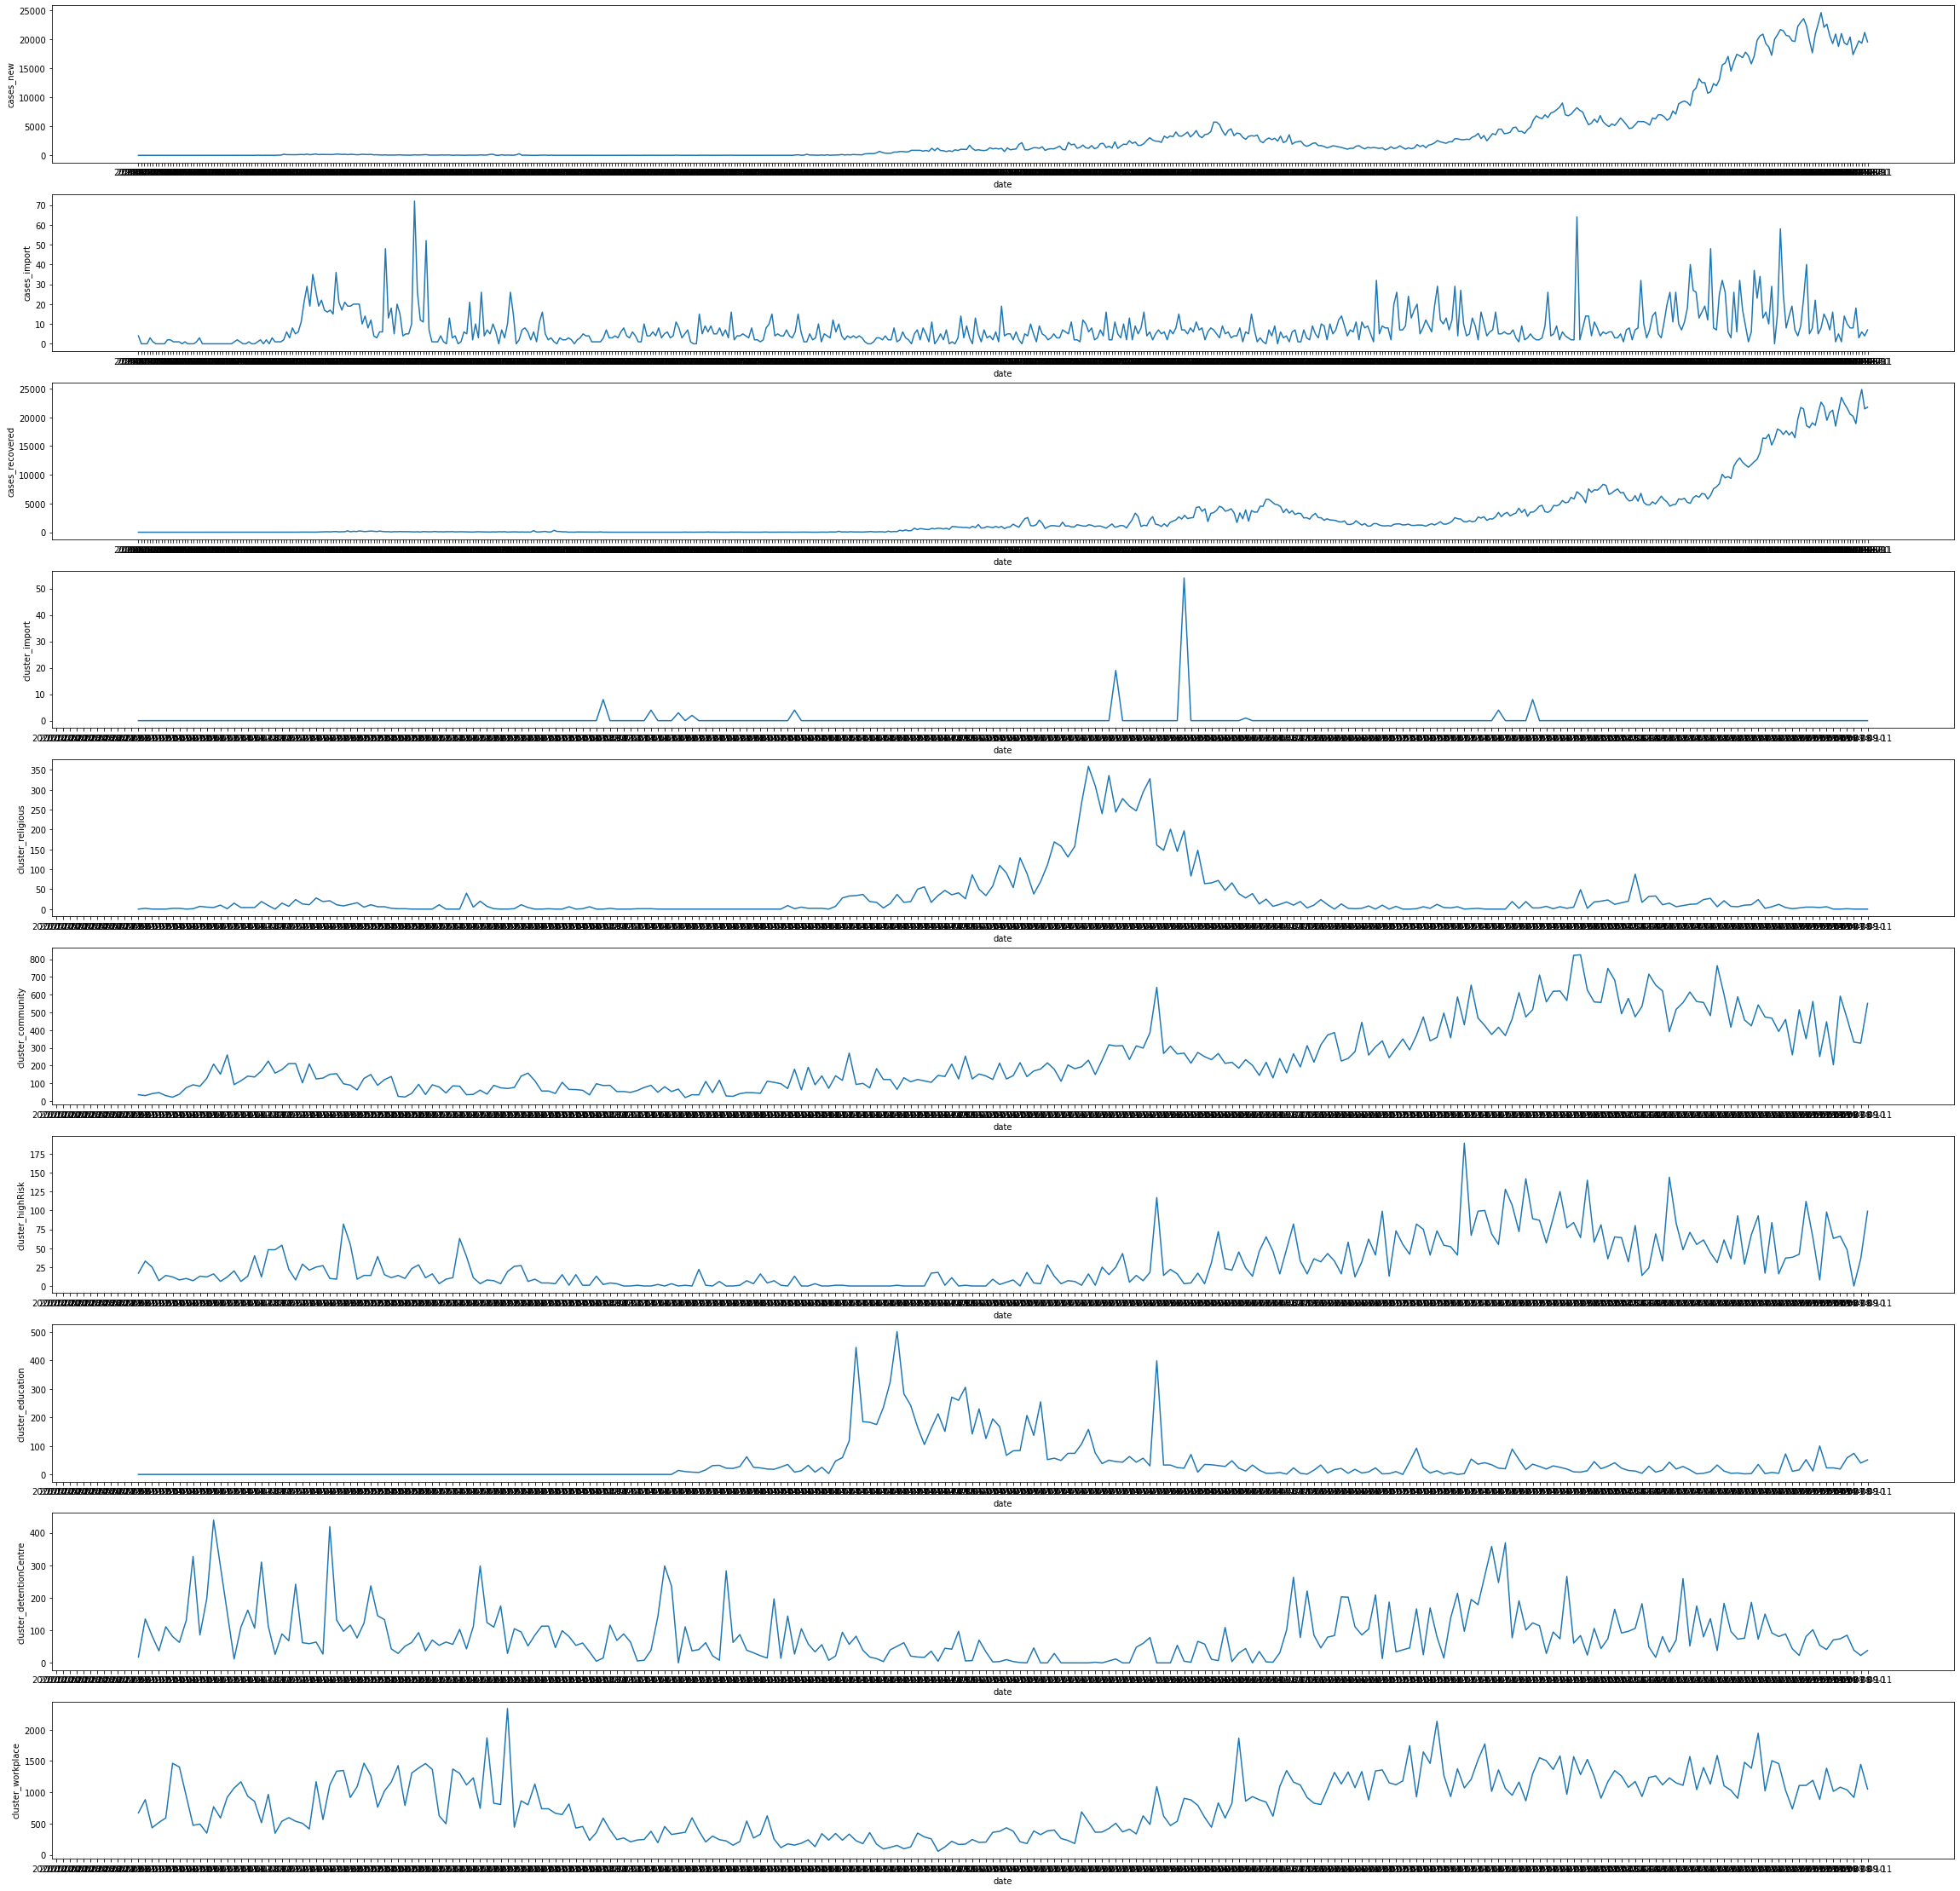

In [7]:
plt.figure(figsize=(40,40))

cols = ["cases_new", "cases_import", "cases_recovered", "cluster_import", "cluster_religious", "cluster_community", "cluster_highRisk", "cluster_education", "cluster_detentionCentre", "cluster_workplace"]

for i in range(len(cols)):
    plt.subplot(len(cols),1,1+i)
    sns.lineplot(x='date', y=cols[i], data=cases_malaysia)

In [8]:
cases_malaysia_months = add_month(cases_malaysia)
cases_malaysia_months_count = count_by_months(cases_malaysia_months)
#cases_malaysia_months_count

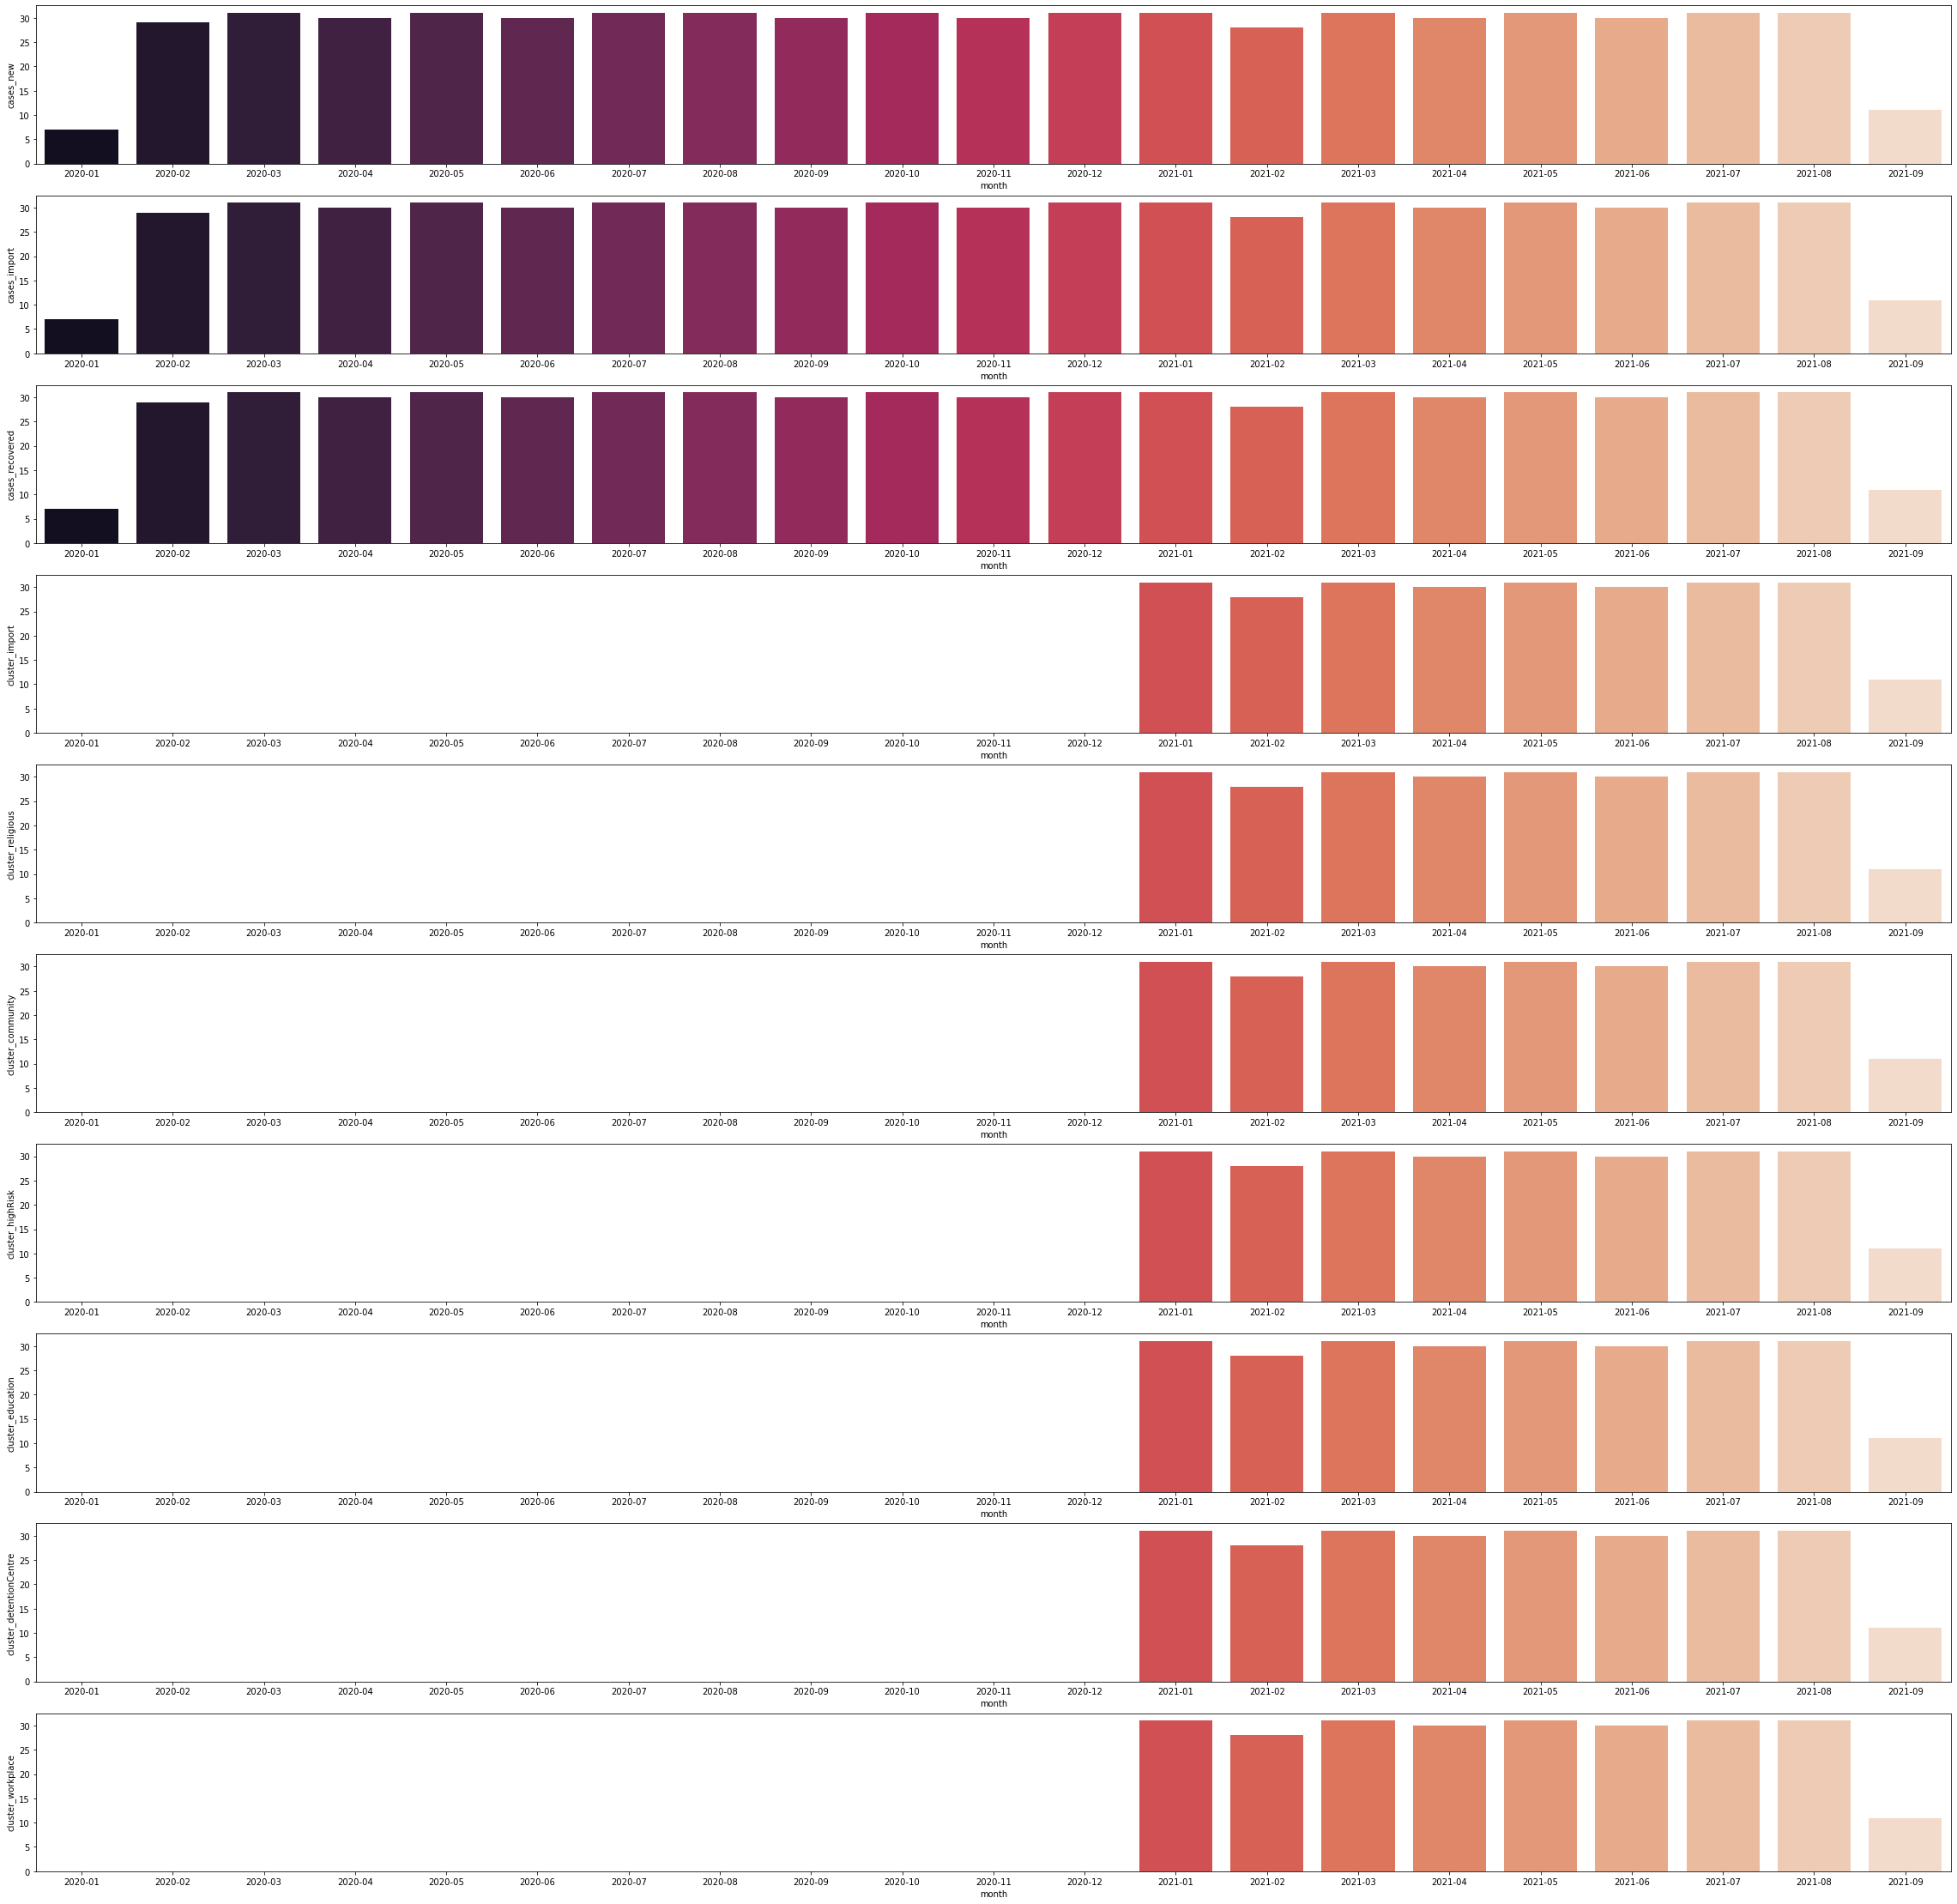

In [9]:
plt.figure(figsize=(40,40))

for i in range(len(cols)):
    plt.subplot(len(cols),1,1+i)
    sns.barplot(x='month', y=cols[i], data=cases_malaysia_months_count, palette='rocket')

#### 1.1.2 cases_state.csv

Daily recorded COVID-19 cases at state level.

In [10]:
cases_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9536 entries, 0 to 9535
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             9536 non-null   object 
 1   state            9536 non-null   object 
 2   cases_import     9536 non-null   int64  
 3   cases_new        9536 non-null   int64  
 4   cases_recovered  9360 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 372.6+ KB


In [11]:
cases_state

,date,state,cases_import,cases_new,cases_recovered
0,2020-01-25,Johor,4,4,NaN
1,2020-01-25,Kedah,0,0,NaN
2,2020-01-25,Kelantan,0,0,NaN
3,2020-01-25,Melaka,0,0,NaN
4,2020-01-25,Negeri Sembilan,0,0,NaN
...,...,...,...,...,...
9531,2021-09-11,Selangor,1,2416,5625.0
9532,2021-09-11,Terengganu,0,953,1151.0
9533,2021-09-11,W.P. Kuala Lumpur,1,555,1068.0
9534,2021-09-11,W.P. Labuan,0,2,2.0


#### 1.1.3 clusters.csv

Exhaustive list of announced clusters with relevant epidemiological datapoints.

In [12]:
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022 entries, 0 to 5021
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cluster          5022 non-null   object
 1   state            5022 non-null   object
 2   district         5022 non-null   object
 3   date_announced   5022 non-null   object
 4   date_last_onset  5022 non-null   object
 5   category         5022 non-null   object
 6   status           5022 non-null   object
 7   cases_new        5022 non-null   int64 
 8   cases_total      5022 non-null   int64 
 9   cases_active     5022 non-null   int64 
 10  tests            5022 non-null   int64 
 11  icu              5022 non-null   int64 
 12  deaths           5022 non-null   int64 
 13  recovered        5022 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 549.4+ KB


In [13]:
clusters

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh SP),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5017,Kluster Jalan Bintulu-Miri,Sarawak,Bintulu,2021-09-09,2021-09-08,community,active,32,33,33,125,0,0,0
5018,Kluster Jalan Selamat Tangkak,Johor,Tangkak,2021-09-09,2021-09-08,community,active,9,10,10,11,0,0,0
5019,Kluster Sungai Segan,Sarawak,Bintulu,2021-09-09,2021-09-08,community,active,24,25,25,47,0,0,0
5020,Kluster Bukit Kenak,Terengganu,Besut,2021-09-09,2021-09-08,community,active,2,37,37,66,0,0,0


In [14]:
clusters_unique_state = clusters['state'].unique()
print(clusters_unique_state)
print(len(clusters_unique_state))

clusters_unique_district = clusters['district'].unique()
print(clusters_unique_district)
print(len(clusters_unique_district))

['WP Kuala Lumpur'
 'WP Kuala Lumpur, WP Putrajaya, Selangor, Negeri Sembilan & Johor'
 'Semua Negeri'
 'Selangor, Negeri Sembilan, WP Kuala Lumpur & WP Putrajaya' 'Pahang'
 'Sarawak'
 'WP Kuala Lumpur, WP Putrajaya, Kedah, Selangor, Perak, Kelantan, Terengganu, Johor, Melaka & Negeri Sembilan'
 'Johor' 'Negeri Sembilan' 'Melaka' 'Selangor' 'Pulau Pinang'
 'Kelantan & Pahang'
 'WP Kuala Lumpur, WP Putrajaya, Selangor & Negeri Sembilan'
 'WP Kuala Lumpur & Pahang' 'Sabah ' 'Sabah'
 'WP Putrajaya, Melaka, Negeri Sembilan, Sarawak & Selangor'
 'Johor & Selangor' 'WP Kuala Lumpur & Selangor'
 'Melaka & Negeri Sembilan'
 'WP Kuala Lumpur, Selangor, Negeri Sembilan & Pahang'
 'Selangor & WP Kuala Lumpur'
 'WP Kuala Lumpur, Selangor & Negeri Sembilan'
 'Selangor & Negeri Sembilan' 'WP Kuala Lumpur & WP Putrajaya'
 'WP Kuala Lumpur & Selangor ' 'Melaka & Selangor'
 'WP Kuala Lumpur & Putrajaya' 'Terengganu' 'Kedah, Perlis & Pulau Pinang'
 'Selangor & WP Putrajaya' 'Perak & Pulau Pinang' 'Kedah

In [15]:
clusters_unique_category = clusters['category'].unique()
print(clusters_unique_category)
print(len(clusters_unique_category))

clusters_unique_status = clusters['status'].unique()
print(clusters_unique_status)
print(len(clusters_unique_status))

['import' 'religious' 'workplace' 'highRisk' 'community' 'detentionCentre'
 'education']
7
['ended' 'active']
2


#### 1.1.4 tests_malaysia.csv

Daily tests (note: not necessarily unique individuals) by type at country level.

1. `date`: yyyy-mm-dd format; data correct as of 1200hrs on that date
2. `rtk-ag`: number of tests done using Antigen Rapid Test Kits (RTK-Ag)
3. `pcr`: number of tests done using Real-time Reverse Transcription Polymerase Chain Reaction (RT-PCR) technology

In [16]:
tests_malaysia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    594 non-null    object
 1   rtk-ag  594 non-null    int64 
 2   pcr     594 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.0+ KB


In [17]:
tests_malaysia

,date,rtk-ag,pcr
0,2020-01-24,0,2
1,2020-01-25,0,5
2,2020-01-26,0,14
3,2020-01-27,0,24
4,2020-01-28,0,53
...,...,...,...
589,2021-09-04,64085,68963
590,2021-09-05,56013,54484
591,2021-09-06,96917,65402
592,2021-09-07,89432,75120


In [18]:
tests_malaysia_months = add_month(tests_malaysia)
tests_malaysia_months_count = count_by_months(tests_malaysia_months)
#tests_malaysia_months_count

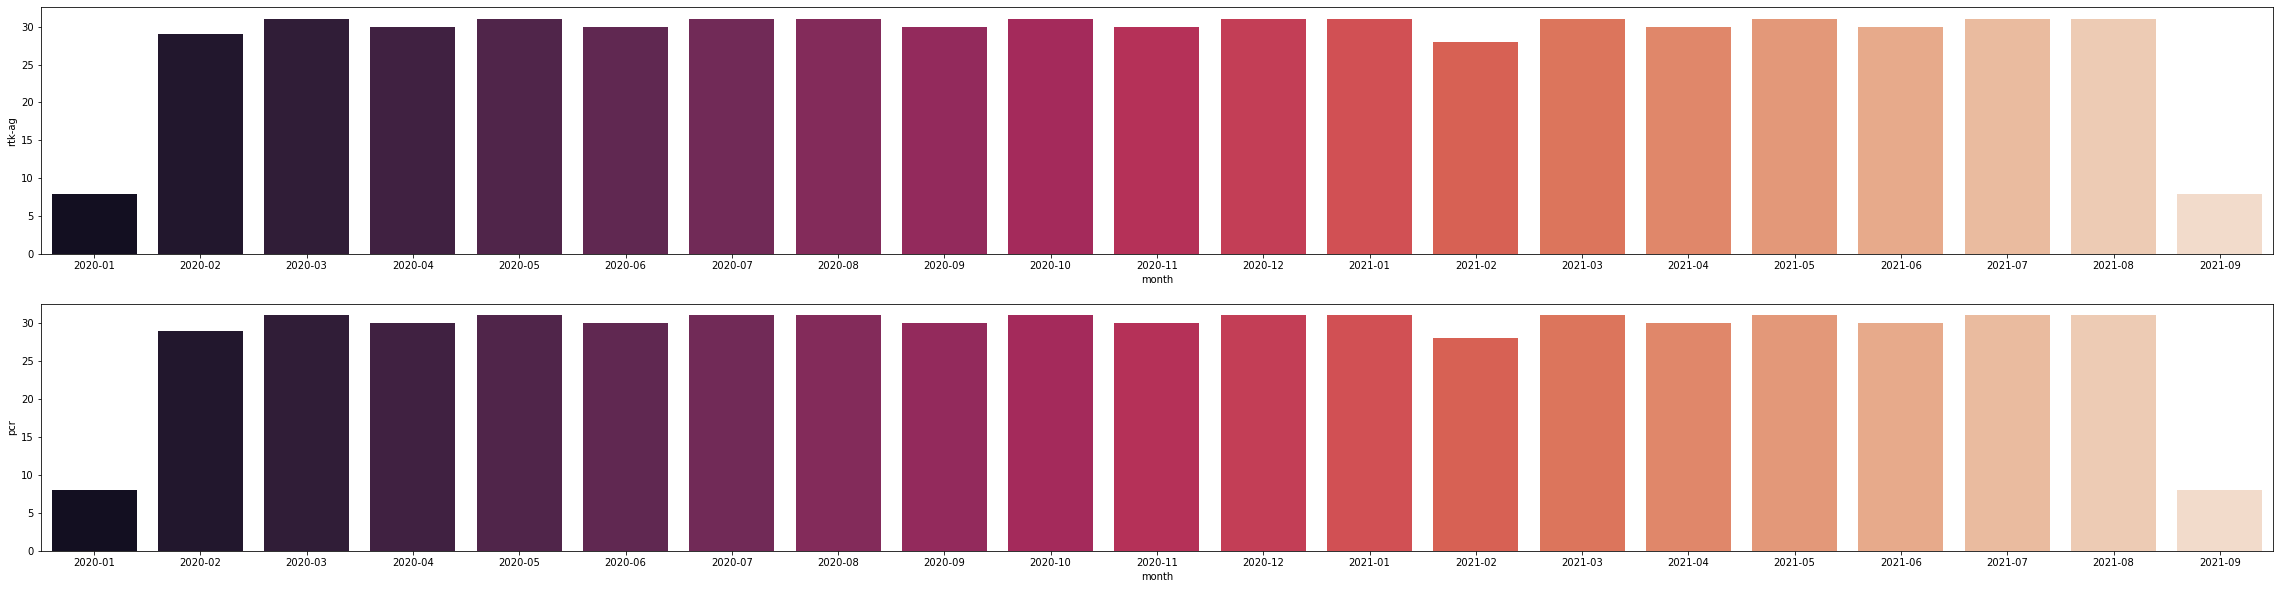

In [19]:
plt.figure(figsize=(40,10))

cols = ["rtk-ag", "pcr"]

for i in range(len(cols)):
    plt.subplot(len(cols),1,1+i)
    sns.barplot(x='month', y=cols[i], data=tests_malaysia_months_count, palette='rocket')

#### 1.1.5 tests_state.csv

Daily tests (note: not necessarily unique individuals) by type at state level.

1. `date`: yyyy-mm-dd format; data correct as of 1200hrs on that date
2. `state`: name of state (present in state file, but not country file)
3. `rtk-ag`: number of tests done using Antigen Rapid Test Kits (RTK-Ag)
4. `pcr`: number of tests done using Real-time Reverse Transcription Polymerase Chain Reaction (RT-PCR) technology

In [20]:
tests_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1120 non-null   object
 1   state   1120 non-null   object
 2   rtk-ag  1120 non-null   int64 
 3   pcr     1120 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 35.1+ KB


In [21]:
tests_state

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1115,2021-09-08,Selangor,23080,13087
1116,2021-09-08,Terengganu,2222,4072
1117,2021-09-08,W.P. Kuala Lumpur,4330,5135
1118,2021-09-08,W.P. Labuan,482,169


### 1.2 Deaths

1. `date`: yyyy-mm-dd format; data correct as of 1200hrs on that date
2. `state`: name of state (present in state file, but not country file)
3. `deaths_new`: deaths due to COVID-19 reported in the 24h since the last report

#### 1.2.1 deaths_malaysia.csv

Daily deaths due to COVID-19 at country level.

In [22]:
deaths_malaysia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            544 non-null    object
 1   deaths_new      544 non-null    int64 
 2   deaths_new_dod  544 non-null    int64 
 3   deaths_bid      544 non-null    int64 
 4   deaths_bid_dod  544 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 21.4+ KB


In [23]:
deaths_malaysia

,date,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod
0,2020-03-17,2,2,0,0
1,2020-03-18,0,0,0,0
2,2020-03-19,0,0,0,0
3,2020-03-20,1,1,0,0
4,2020-03-21,4,4,0,0
...,...,...,...,...,...
539,2021-09-07,311,134,93,27
540,2021-09-08,361,118,102,30
541,2021-09-09,323,72,55,6
542,2021-09-10,341,38,102,2


#### 1.2.2 deaths_state.csv

Daily deaths due to COVID-19 at state level.

In [24]:
deaths_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            8704 non-null   object
 1   state           8704 non-null   object
 2   deaths_new      8704 non-null   int64 
 3   deaths_new_dod  8704 non-null   int64 
 4   deaths_bid      8704 non-null   int64 
 5   deaths_bid_dod  8704 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 408.1+ KB


In [25]:
deaths_state

,date,state,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod
0,2020-03-17,Johor,1,1,0,0
1,2020-03-17,Kedah,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0
...,...,...,...,...,...,...
8699,2021-09-11,Selangor,359,0,2,0
8700,2021-09-11,Terengganu,6,1,1,0
8701,2021-09-11,W.P. Kuala Lumpur,8,1,1,0
8702,2021-09-11,W.P. Labuan,0,0,0,0


### 1.3 Healthcare

#### 1.3.1 hospital.csv

Flow of patients to/out of hospitals, with capacity and utilisation.

1. `date`: yyyy-mm-dd format; data correct as of 2359hrs on that date
2. `state`: name of state, with similar qualification on exhaustiveness of date-state combos as PKRC data
3. `beds`: total hospital beds (with related medical infrastructure)
3. `beds_covid`: total beds dedicated for COVID-19
4. `beds_noncrit`: total hospital beds for non-critical care
5. `admitted_x`: number of individuals in category `x` admitted to hospitals, where `x` can be suspected/probable, COVID-19 positive, or non-COVID
6. `discharged_x`: number of individuals in category `x` discharged from hospitals
7. `hosp_x`: total number of individuals in category `x` in hospitals; this is a stock variable altered by flows from admissions and discharges


In [26]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8179 entries, 0 to 8178
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              8179 non-null   object
 1   state             8179 non-null   object
 2   beds              8179 non-null   int64 
 3   beds_covid        8179 non-null   int64 
 4   beds_noncrit      8179 non-null   int64 
 5   admitted_pui      8179 non-null   int64 
 6   admitted_covid    8179 non-null   int64 
 7   admitted_total    8179 non-null   int64 
 8   discharged_pui    8179 non-null   int64 
 9   discharged_covid  8179 non-null   int64 
 10  discharged_total  8179 non-null   int64 
 11  hosp_covid        8179 non-null   int64 
 12  hosp_pui          8179 non-null   int64 
 13  hosp_noncovid     8179 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 894.7+ KB


In [27]:
hospital

,date,state,beds,beds_covid,beds_noncrit,admitted_pui,admitted_covid,admitted_total,discharged_pui,discharged_covid,discharged_total,hosp_covid,hosp_pui,hosp_noncovid
0,2020-03-24,Johor,1440,434,1408,0,0,0,0,0,0,18,9,1
1,2020-03-24,Kedah,1218,143,1183,0,0,0,0,0,0,46,5,12
2,2020-03-24,Kelantan,1463,280,1424,9,6,15,1,0,1,78,58,23
3,2020-03-24,Melaka,1091,82,1065,0,0,0,0,0,0,19,10,12
4,2020-03-24,Negeri Sembilan,1223,253,1205,0,0,0,0,0,0,90,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8174,2021-09-11,Selangor,6302,3537,5916,269,276,545,78,279,357,1599,398,1722
8175,2021-09-11,Terengganu,1557,491,1496,15,58,73,19,30,49,360,52,848
8176,2021-09-11,W.P. Kuala Lumpur,4753,1022,4533,0,55,55,4,74,78,509,98,1285
8177,2021-09-11,W.P. Labuan,122,106,99,0,0,0,0,0,0,6,0,81


#### 1.3.2 icu.csv

Capacity and utilisation of intensive care unit (ICU) beds.

1. `date`: yyyy-mm-dd format; data correct as of 2359hrs on that date
2. `state`: name of state, with similar qualification on exhaustiveness of date-state combos as PKRC data
3. `beds_icu`: total gazetted ICU beds
4. `beds_icu_rep`: total beds aside from (3) which are temporarily or permanently designated to be under the care of Anaesthesiology & Critical Care departments
5. `beds_icu_total`: total critical care beds available (with related medical infrastructure)
6. `beds_icu_covid`: total critical care beds dedicated for COVID-19
7. `vent`: total available ventilators
8. `vent_port`: total available portable ventilators
9. `icu_x`: total number of individuals in category `x` under intensive care, where `x` can be  suspected/probable, COVID-19 positive, or non-COVID; this is a stock variable
10. `vent_x`: total number of individuals in category `x` on mechanical ventilation, where `x` can be suspected/probable, COVID-19 positive, or non-COVID; this is a stock variable

In [28]:
icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8179 entries, 0 to 8178
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            8179 non-null   object
 1   state           8179 non-null   object
 2   beds_icu        8179 non-null   int64 
 3   beds_icu_rep    8179 non-null   int64 
 4   beds_icu_total  8179 non-null   int64 
 5   beds_icu_covid  8179 non-null   int64 
 6   vent            8179 non-null   int64 
 7   vent_port       8179 non-null   int64 
 8   icu_covid       8179 non-null   int64 
 9   icu_pui         8179 non-null   int64 
 10  icu_noncovid    8179 non-null   int64 
 11  vent_covid      8179 non-null   int64 
 12  vent_pui        8179 non-null   int64 
 13  vent_noncovid   8179 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 894.7+ KB


In [29]:
icu

,date,state,beds_icu,beds_icu_rep,beds_icu_total,beds_icu_covid,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid
0,2020-03-24,Johor,10,22,32,10,11,2,0,0,1,0,0,0
1,2020-03-24,Kedah,35,0,35,16,34,0,2,1,12,1,1,0
2,2020-03-24,Kelantan,39,0,39,20,42,4,1,0,20,1,0,0
3,2020-03-24,Melaka,26,0,26,12,23,4,0,2,12,0,1,0
4,2020-03-24,Negeri Sembilan,18,0,18,10,14,9,0,0,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8174,2021-09-11,Selangor,187,199,386,312,443,196,246,32,51,147,2,37
8175,2021-09-11,Terengganu,29,32,61,39,58,31,27,0,15,24,0,15
8176,2021-09-11,W.P. Kuala Lumpur,129,91,220,174,218,87,110,0,37,71,0,29
8177,2021-09-11,W.P. Labuan,5,18,23,18,11,12,0,0,5,0,0,4


#### 1.3.3 pkrc.csv

Flow of patients to/out of Covid-19 Quarantine and Treatment Centres (PKRC), with capacity and utilisation.

1. `date`: yyyy-mm-dd format; data correct as of 2359hrs on that date
2. `state`: name of state; note that (unlike with other datasets), it is not necessary that there be an observation for every state on every date. for instance, there are no PKRCs in W.P. Kuala Lumpur and W.P Putrajaya.
3. `beds`: total PKRC beds (with related medical infrastructure)
4. `admitted_x`: number of individuals in category `x` admitted to PKRCs, where `x` can be suspected/probable, COVID-19 positive, or non-COVID
5. `discharged_x`: number of individuals in category `x` discharged from PKRCs
6. `pkrc_x`: total number of individuals in category `x` in PKRCs; this is a stock variable altered by flows from admissions and discharges


In [30]:
pkrc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6185 entries, 0 to 6184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             6185 non-null   object
 1   state            6185 non-null   object
 2   beds             6185 non-null   int64 
 3   admitted_pui     6185 non-null   int64 
 4   admitted_covid   6185 non-null   int64 
 5   admitted_total   6185 non-null   int64 
 6   discharge_pui    6185 non-null   int64 
 7   discharge_covid  6185 non-null   int64 
 8   discharge_total  6185 non-null   int64 
 9   pkrc_covid       6185 non-null   int64 
 10  pkrc_pui         6185 non-null   int64 
 11  pkrc_noncovid    6185 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 580.0+ KB


In [31]:
pkrc

,date,state,beds,admitted_pui,admitted_covid,admitted_total,discharge_pui,discharge_covid,discharge_total,pkrc_covid,pkrc_pui,pkrc_noncovid
0,2020-03-28,Kelantan,147,0,0,0,0,0,0,0,53,0
1,2020-03-28,Perlis,54,0,0,0,0,0,0,8,3,0
2,2020-03-28,Pulau Pinang,58,0,0,0,0,0,0,13,0,0
3,2020-03-28,Sarawak,74,0,0,0,0,0,0,22,0,0
4,2020-03-28,Selangor,1452,0,12,12,0,5,5,145,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6180,2021-09-11,Sabah,5011,27,342,369,6,406,412,3063,138,0
6181,2021-09-11,Sarawak,10256,6,155,161,2,131,133,6553,722,0
6182,2021-09-11,Selangor,4114,5,432,437,2,407,409,2836,0,0
6183,2021-09-11,Terengganu,2797,41,352,393,28,290,318,1670,167,0


### 1.4 Static Data

#### 1.4.1 population.csv

Total, adult (≥18), and elderly (≥60) population at state level.

In [32]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   17 non-null     object
 1   idxs    17 non-null     int64 
 2   pop     17 non-null     int64 
 3   pop_18  17 non-null     int64 
 4   pop_60  17 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 808.0+ bytes


In [33]:
population

,state,idxs,pop,pop_18,pop_60
0,Malaysia,0,32657400,23409600,3502000
1,Johor,1,3781000,2711900,428700
2,Kedah,2,2185100,1540600,272500
3,Kelantan,3,1906700,1236200,194100
4,Melaka,4,932700,677400,118500
5,Negeri Sembilan,5,1128800,814400,145000
6,Pahang,6,1678700,1175800,190200
7,Pulau Pinang,7,1773600,1367200,239200
8,Perak,8,2510300,1862700,397300
9,Perlis,9,254900,181200,35100


<AxesSubplot:xlabel='state', ylabel='pop_60'>

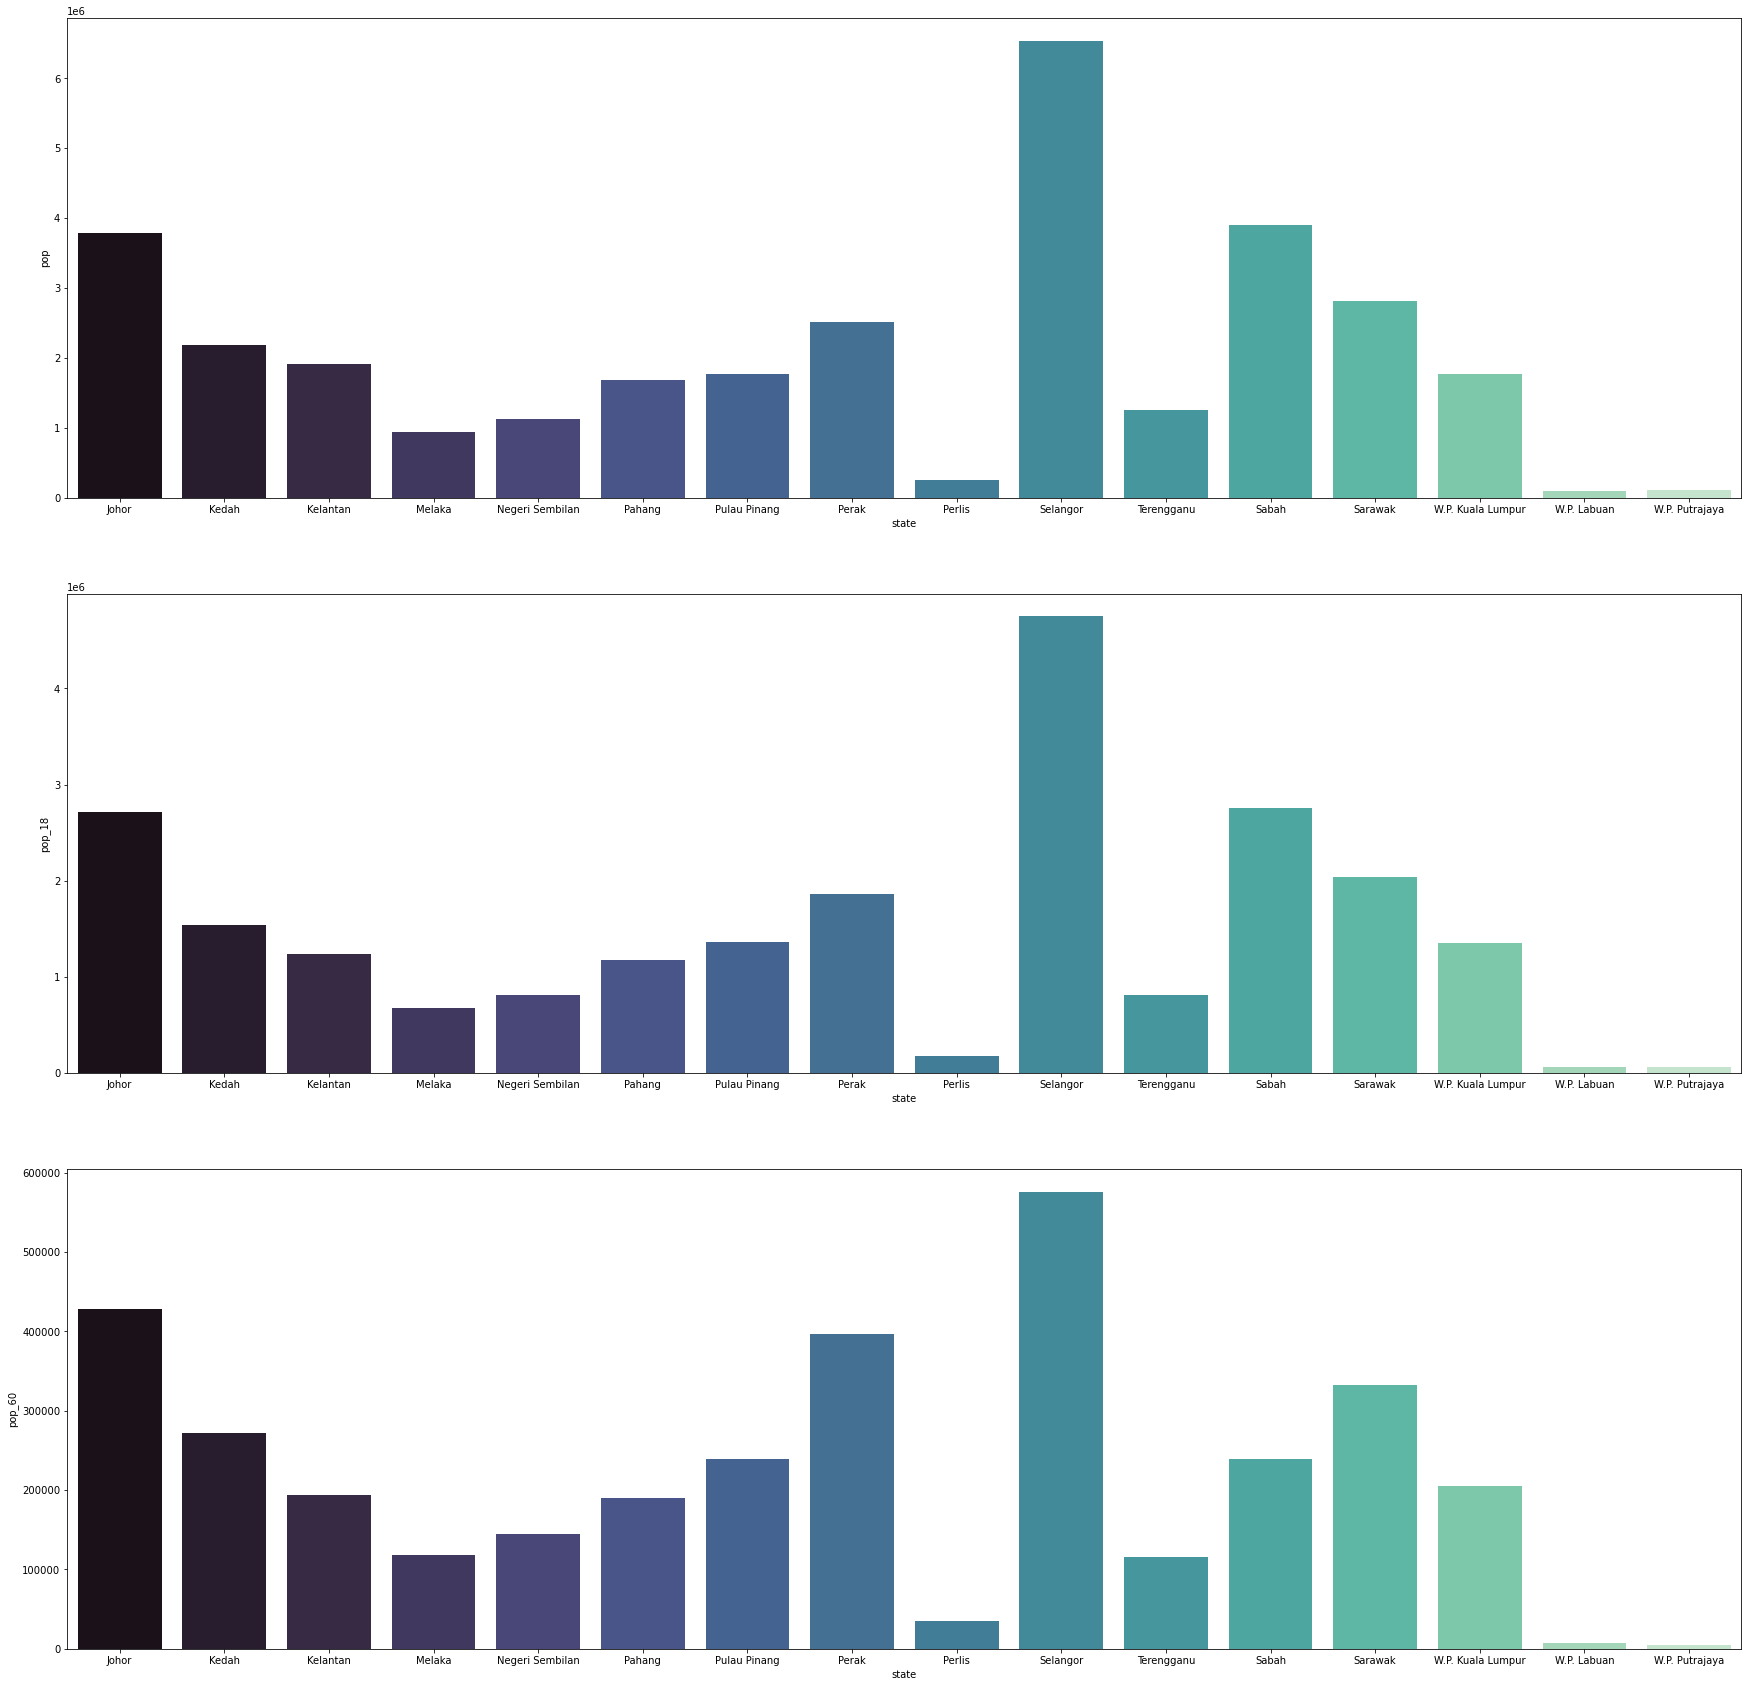

In [34]:
state_population = population.drop(0) # drop Malaysia population
state_population.reset_index(inplace=True, drop=True)

plt.figure(figsize=(30,30))
plt.subplot(311)
sns.barplot(x='state', y='pop', data=state_population, palette='mako')
plt.subplot(312)
sns.barplot(x='state', y='pop_18', data=state_population, palette='mako')
plt.subplot(313)
sns.barplot(x='state', y='pop_60', data=state_population, palette='mako')

### 1.5 Outliers Detection

In [35]:
def check_outlier(df):
    numeric_columns = df.describe().columns.copy()
    num_of_columns = len(numeric_columns)
    
    for i in range(math.ceil(num_of_columns/2)):
        c = 2*i
        
        plt.figure(figsize=(20,2))
        plt.subplot(1, 2, 1)
        plot_boxplot(df[numeric_columns[c]], xlabel=numeric_columns[c])
        plt.subplot(1, 2, 2)
        try:
            plot_boxplot(df[numeric_columns[c+1]], xlabel=numeric_columns[c+1])
        except IndexError:
            plt.xticks([]), plt.yticks([])
            plt.axis("off")
        plt.show()
    
def plot_boxplot(series, title='', xlabel=''):
    bp = sns.boxplot(x=series)
    bp.set(title=title,
           xlabel=xlabel)
    return bp

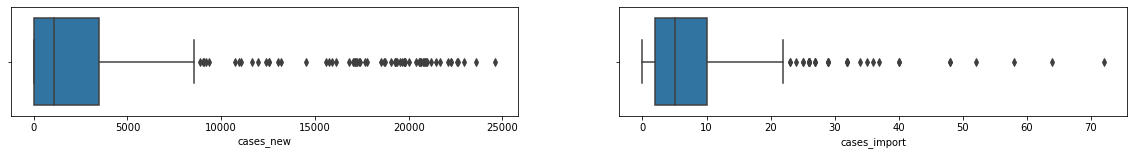

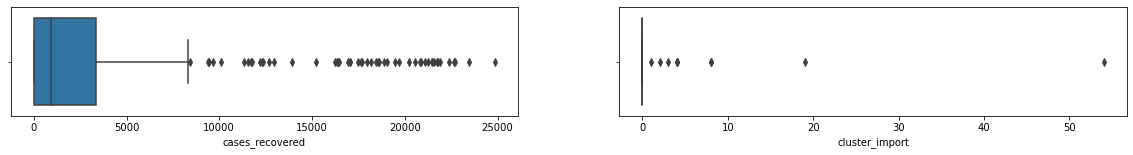

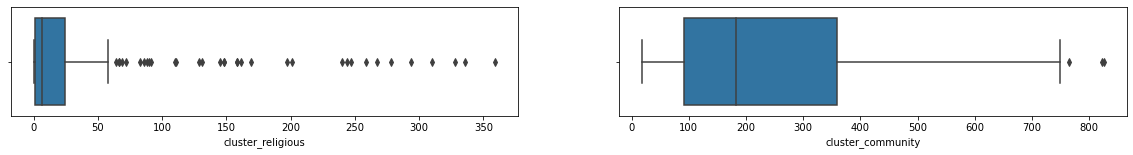

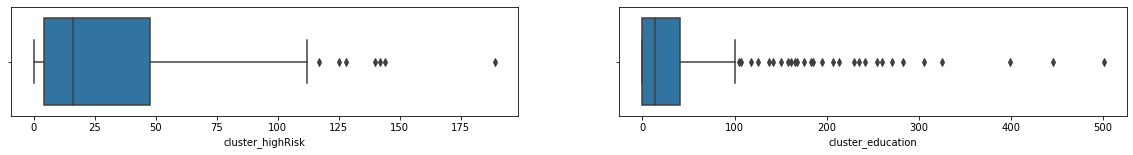

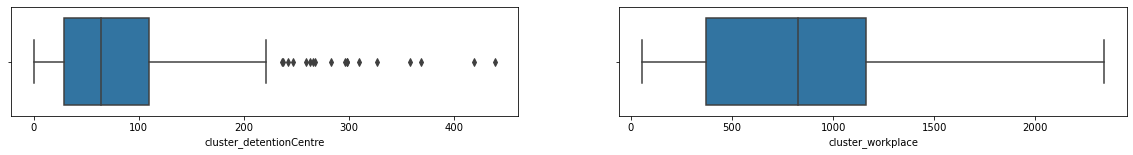

In [36]:
check_outlier(cases_malaysia)

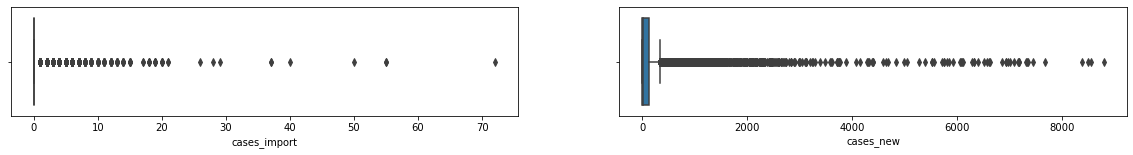

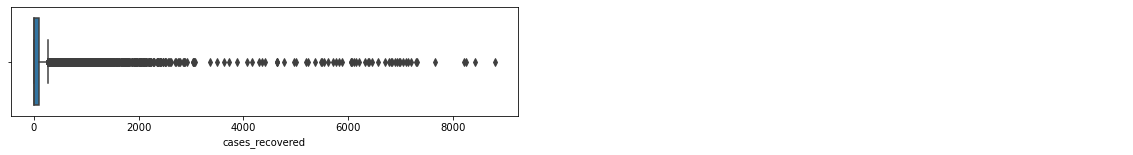

In [37]:
check_outlier(cases_state)

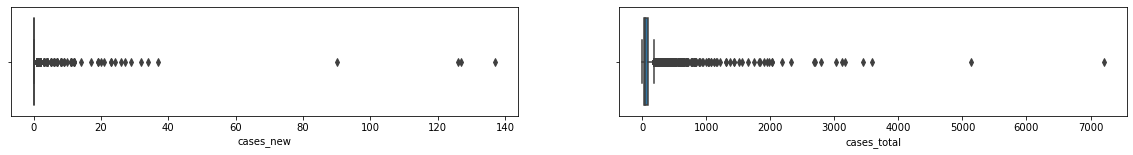

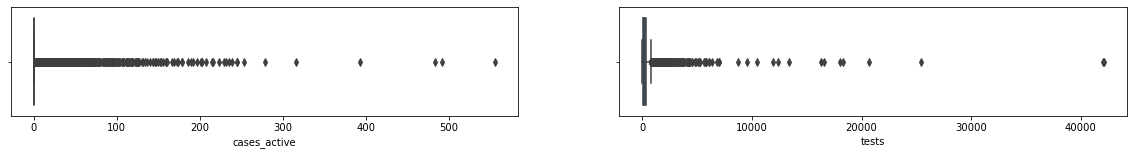

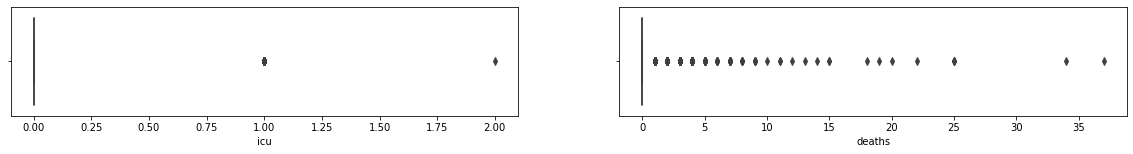

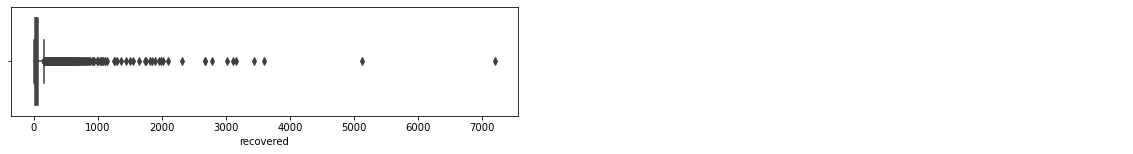

In [38]:
check_outlier(clusters)

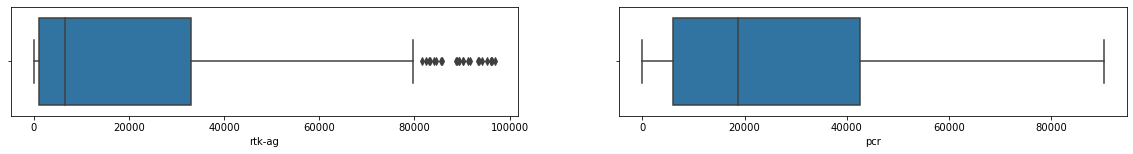

In [39]:
check_outlier(tests_malaysia)

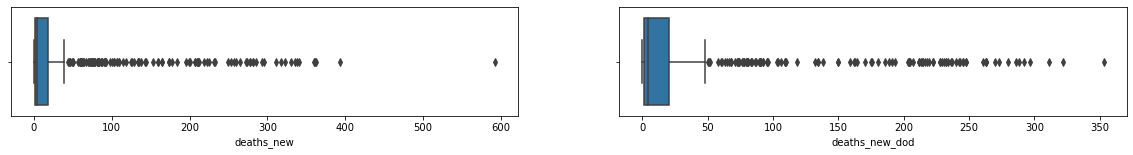

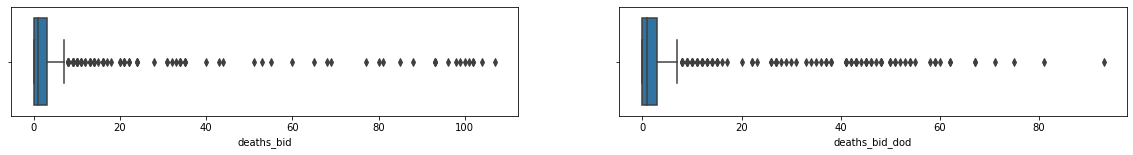

In [40]:
check_outlier(deaths_malaysia)

### 1.6 Identifying Missing Values

In [41]:
def get_nan(df):
    missing_value = df[df.isna().values.any(axis=1)]
    rows = missing_value.shape[0]
    print(rows, "rows with missing values")
    
    if rows > 0:
        print(df.isna().sum(), "\n")

In [42]:
get_nan(cases_malaysia)
get_nan(cases_state)
get_nan(clusters)
get_nan(tests_malaysia)
get_nan(tests_state)

342 rows with missing values
date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
month                        0
dtype: int64 

176 rows with missing values
date                 0
state                0
cases_import         0
cases_new            0
cases_recovered    176
dtype: int64 

0 rows with missing values
0 rows with missing values
0 rows with missing values


In [43]:
get_nan(deaths_malaysia)
get_nan(deaths_state)

0 rows with missing values
0 rows with missing values


In [44]:
get_nan(hospital)
get_nan(icu)
get_nan(pkrc)

0 rows with missing values
0 rows with missing values
0 rows with missing values


In [45]:
get_nan(population)

0 rows with missing values


**CSV files with missing values:**

1. `cases_malaysia` - 342 out of 596 rows
2. `cases_state` - 176 out of 9536 rows 

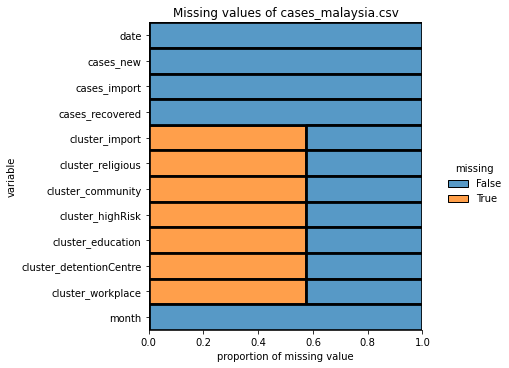

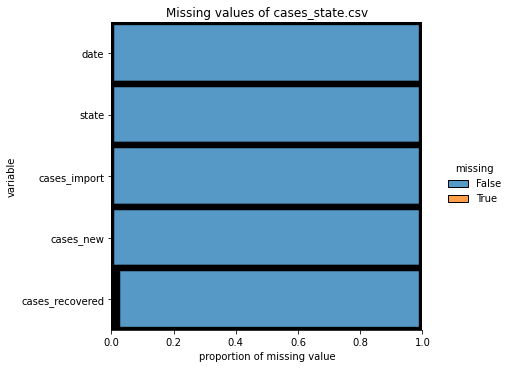

In [46]:
def visual_nan(df, name=""):
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                     y="variable",
                     hue="missing",
                     multiple="fill",
                     aspect=1.25)
    plt.xlabel('proportion of missing value')
    plt.title(f"Missing values of {name}")

    return ax

visual_nan(cases_malaysia, "cases_malaysia.csv")
visual_nan(cases_state, "cases_state.csv")

## 2. Data Transformation

In [47]:
# list of unique states
states = tests_state['state'].unique()

print(len(states))
for s in states:
    print(s)

16
Johor
Kedah
Kelantan
Melaka
Negeri Sembilan
Pahang
Perak
Perlis
Pulau Pinang
Sabah
Sarawak
Selangor
Terengganu
W.P. Kuala Lumpur
W.P. Labuan
W.P. Putrajaya


In [48]:
# plot a time series scatterplot according to column
# suitable for: cases_state, tests_state, deaths_state

def plot_scatterplot(df, column, state_list):
    for state in state_list:
        temp_df = df[df['state'] == state].copy()
        temp_df.reset_index(inplace=True, drop=True)

        ax = sns.scatterplot(x='date', y=column, data=temp_df)
        plt.title(state)
        plt.show()

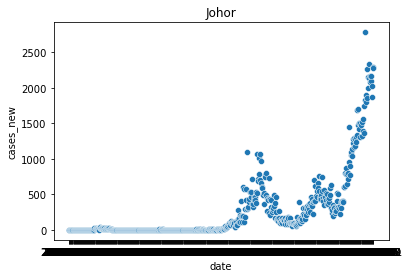

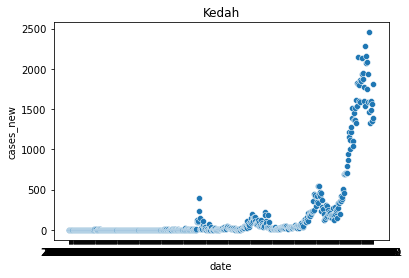

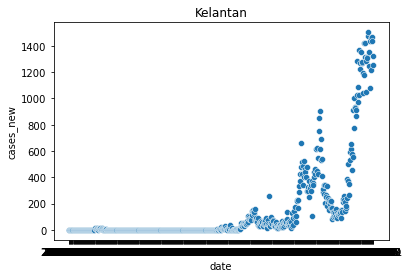

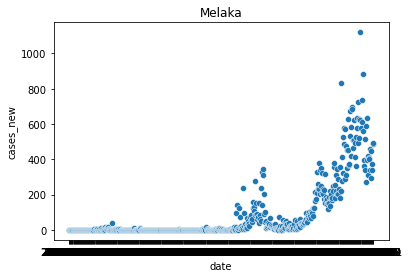

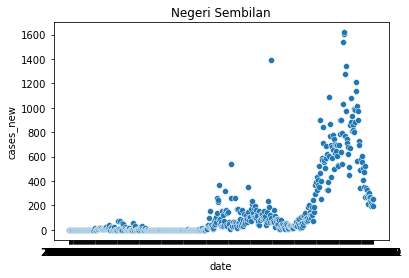

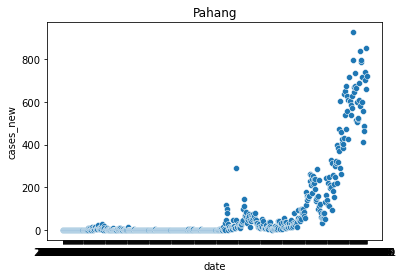

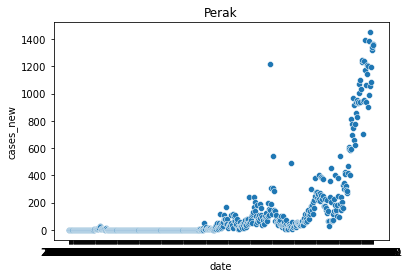

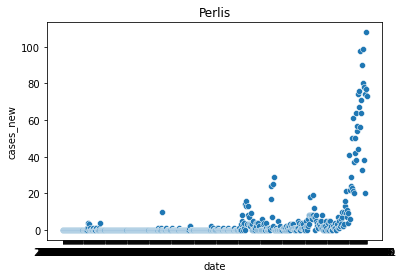

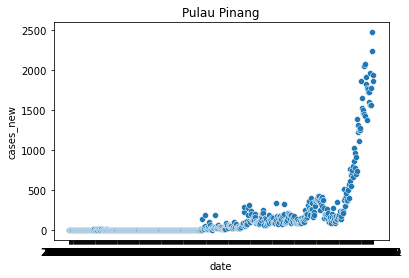

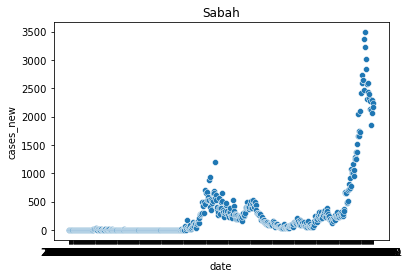

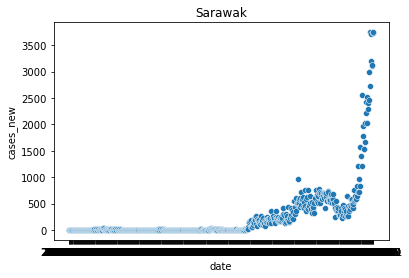

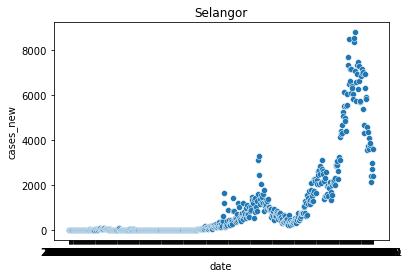

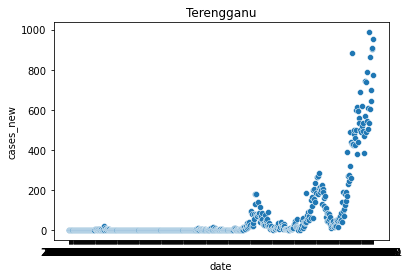

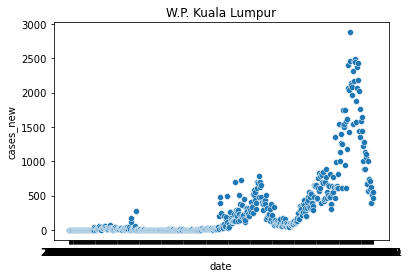

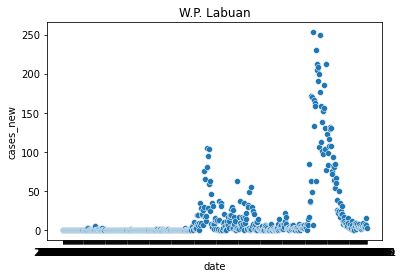

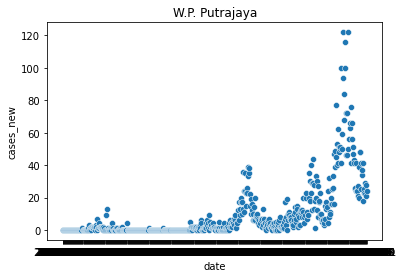

In [49]:
plot_scatterplot(cases_state, 'cases_new', states)

### 2.1 Merging

Merging `cases_state`, `tests_state`, and `deaths_state`.

However, these 3 datasets have different starting date and ending date.

| Dataset         | Start date | End date   | Number of rows |
| --------------- | ---------- | ---------- | -------------- |
| cases_state     | 2020-01-25 | 2021-09-11 | 9536           |
| tests_state     | 2021-07-01 | 2021-09-08 | 1120           |
| deaths_state    | 2020-03-17 | 2021-09-11 | 8704           |

Hence we selected the timeframe: `2021-07-01` to `2021-09-08` (70 days) which is covered in all 3 datasets. First we performed an inner merge between cases_state with tests_state. Then we merged the resulting dataframe with deaths_state.

In [50]:
tests_state

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1115,2021-09-08,Selangor,23080,13087
1116,2021-09-08,Terengganu,2222,4072
1117,2021-09-08,W.P. Kuala Lumpur,4330,5135
1118,2021-09-08,W.P. Labuan,482,169


In [51]:
# merge tests_state and cases_state together
df_inner_join = (pd.merge(tests_state, cases_state, on='date', how='inner', indicator=True)).set_index('date')
df_cases_state = df_inner_join[df_inner_join['state_x'] == df_inner_join['state_y']].copy()
df_cases_state.drop(['state_y', '_merge'], axis=1, inplace=True)

# merge deaths_state
df_inner_join_2 = (pd.merge(df_cases_state, deaths_state, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests_deaths = df_inner_join_2[df_inner_join_2['state_x'] == df_inner_join_2['state']].copy()
df_cases_tests_deaths.drop(['state', '_merge'], axis=1, inplace=True)
df_cases_tests_deaths.rename(columns={'state_x': 'state'}, inplace=True)

# reset index
df_cases_tests_deaths.reset_index(inplace = True)

# rearranging the columns
cols = df_cases_tests_deaths.columns.tolist()
df_cases_tests_deaths = df_cases_tests_deaths[cols[:2]+cols[4:7]+cols[2:4]+cols[7:]]
df_cases_tests_deaths

,date,state,cases_import,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod
0,2021-07-01,Johor,1,270,361.0,2749,3670,6,8,0,2
1,2021-07-01,Kedah,0,250,186.0,2073,1297,0,3,0,0
2,2021-07-01,Kelantan,0,108,208.0,1348,1966,0,1,0,0
3,2021-07-01,Melaka,0,311,317.0,1049,2132,4,2,0,1
4,2021-07-01,Negeri Sembilan,0,692,883.0,2151,3306,6,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1115,2021-09-08,Selangor,0,2989,6062.0,23080,13087,67,5,17,0
1116,2021-09-08,Terengganu,0,904,521.0,2222,4072,9,4,0,1
1117,2021-09-08,W.P. Kuala Lumpur,2,537,1081.0,4330,5135,34,2,16,0
1118,2021-09-08,W.P. Labuan,0,7,14.0,482,169,0,0,0,0


In [52]:
df_cases_tests_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1120 non-null   object 
 1   state            1120 non-null   object 
 2   cases_import     1120 non-null   int64  
 3   cases_new        1120 non-null   int64  
 4   cases_recovered  1120 non-null   float64
 5   rtk-ag           1120 non-null   int64  
 6   pcr              1120 non-null   int64  
 7   deaths_new       1120 non-null   int64  
 8   deaths_new_dod   1120 non-null   int64  
 9   deaths_bid       1120 non-null   int64  
 10  deaths_bid_dod   1120 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 96.4+ KB


Checking if there is any missing value.

In [53]:
get_nan(df_cases_tests_deaths)

0 rows with missing values


Checking for outliers.

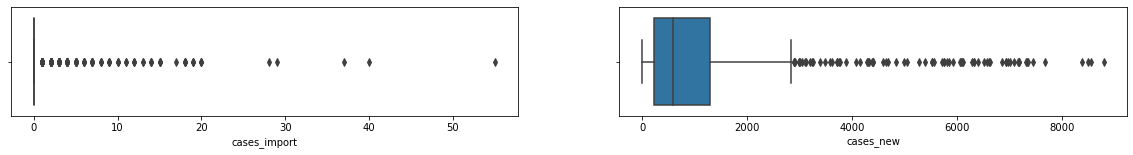

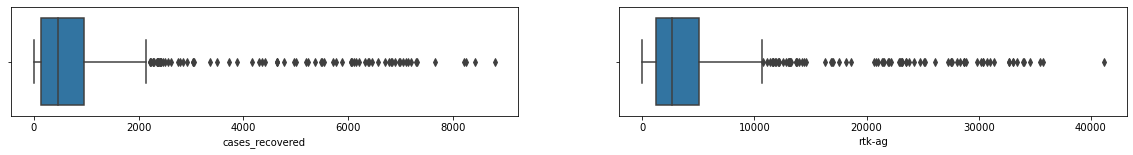

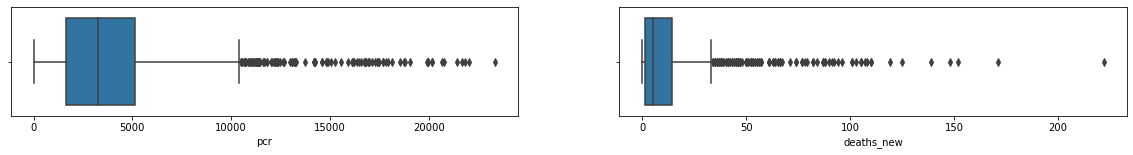

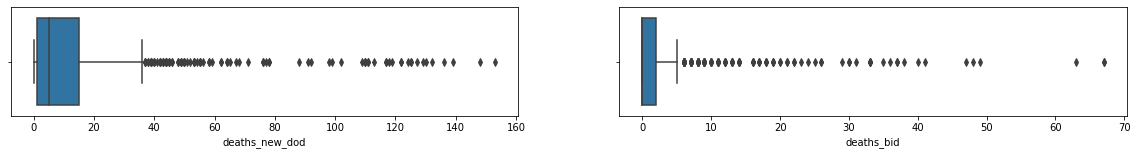

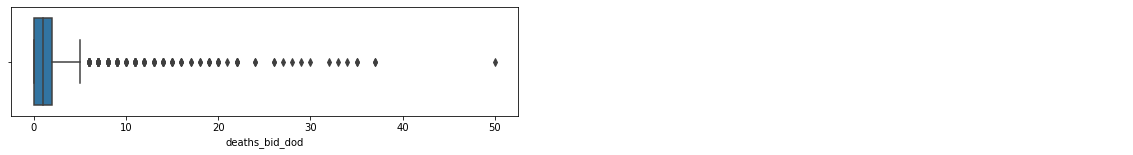

In [54]:
check_outlier(df_cases_tests_deaths)

The columns in `df_cases_tests_deaths`

1. `date`: yyyy-mm-dd format; data correct as of 1200hrs on that date
2. `state`: name of state (present in state file, but not country file) 
3. `cases_import`: 
4. `cases_new`: cases reported in the 24h since the last report (except for 16th March 2020, for which the data is cumulative)
5. `cases_recovered`:
6. `rtk-ag`: number of tests done using Antigen Rapid Test Kits (RTK-Ag)
7. `pcr`: number of tests done using Real-time Reverse Transcription Polymerase Chain Reaction (RT-PCR) technologyb
8. `deaths_new`: deaths due to COVID-19 reported in the 24h since the last report
9. `deaths_new_dod`:
10. `deaths_bid`:  
11. `deaths_bid_dod`:

### 2.2 Binning

Binning is applied to the `cases_new` column of the above cleaned data. This essential for building a classification model later.

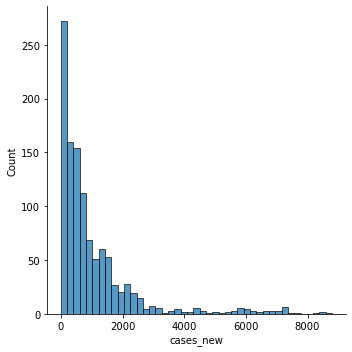

In [55]:
sns.displot(df_cases_tests_deaths, x='cases_new')
plt.show()

In [56]:
bins = np.linspace(min(df_cases_tests_deaths['cases_new']), max(df_cases_tests_deaths['cases_new']), 4)
bins

array([   0.        , 2930.66666667, 5861.33333333, 8792.        ])

In [57]:
group_names = ['High', 'Moderate', 'Low']
df_cases_tests_deaths['cases_new_binned'] = pd.cut(df_cases_tests_deaths['cases_new'], bins, labels=group_names, include_lowest=True)

df_cases_tests_deaths.head()

,date,state,cases_import,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod,cases_new_binned
0,2021-07-01,Johor,1,270,361.0,2749,3670,6,8,0,2,High
1,2021-07-01,Kedah,0,250,186.0,2073,1297,0,3,0,0,High
2,2021-07-01,Kelantan,0,108,208.0,1348,1966,0,1,0,0,High
3,2021-07-01,Melaka,0,311,317.0,1049,2132,4,2,0,1,High
4,2021-07-01,Negeri Sembilan,0,692,883.0,2151,3306,6,11,0,1,High


Text(0, 0.5, 'Frequency')

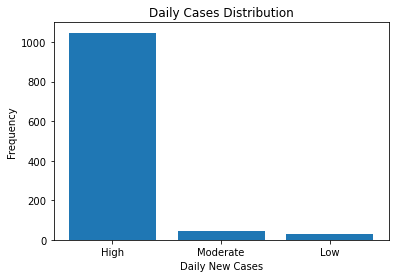

In [58]:
plt.bar(group_names, df_cases_tests_deaths['cases_new_binned'].value_counts())
plt.title('Daily Cases Distribution')
plt.xlabel('Daily New Cases')
plt.ylabel('Frequency')

## 3. Identifying Features

Observing the strong features and indicators to daily cases for all states

### 3.1 Correlation among states

In [59]:
# returns a list of correlation value between target state and other states
def get_correlation(df, column, target_state):
    
    target_df = df[df['state'] == target_state].copy()
    target_df.reset_index(inplace=True, drop=True)
    
    correlation = []
    
    state_list = df['state'].unique()
    for state in state_list:
        if state == target_state:
            continue
        
        temp_df = df[df['state'] == state].copy()
        temp_df.reset_index(inplace=True, drop=True)
        
        corr = target_df[column].corr(temp_df[column])
        
        if math.isnan(corr): # no correlation
            correlation.append(0)
        else:
            correlation.append(corr)
            
    return correlation

# generate correlation report
def show_correlation_among_states(target_state):
    
    numeric_columns = df_cases_tests_deaths.describe().columns
    state_list = df_cases_tests_deaths['state'].unique().tolist()
    state_list.remove(target_state)

    corr_all = []

    for col in numeric_columns:
        corr_all.append(get_correlation(df_cases_tests_deaths, col, target_state))

    df = pd.DataFrame(np.array(corr_all).T, 
                      columns=numeric_columns,
                      index=state_list)

    plt.figure(figsize=(20, 8))
    ax = sns.heatmap(df, vmin=-1, vmax=1, annot=True,
                     cmap=sns.diverging_palette(220, 20, as_cmap=True))
    ax.set_xlabel(f'variables')
    ax.set_ylabel(f'states')
    ax.set_title(f'Correlation of {target_state} with other states')
    return ax

<AxesSubplot:title={'center':'Correlation of Pahang with other states'}, xlabel='variables', ylabel='states'>

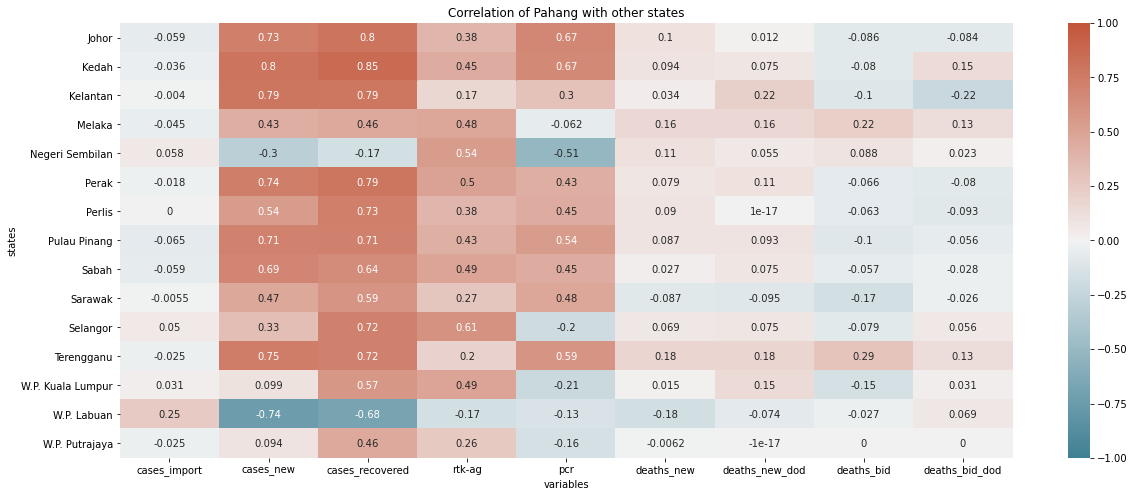

In [60]:
show_correlation_among_states('Pahang')

<AxesSubplot:title={'center':'Correlation of Johor with other states'}, xlabel='variables', ylabel='states'>

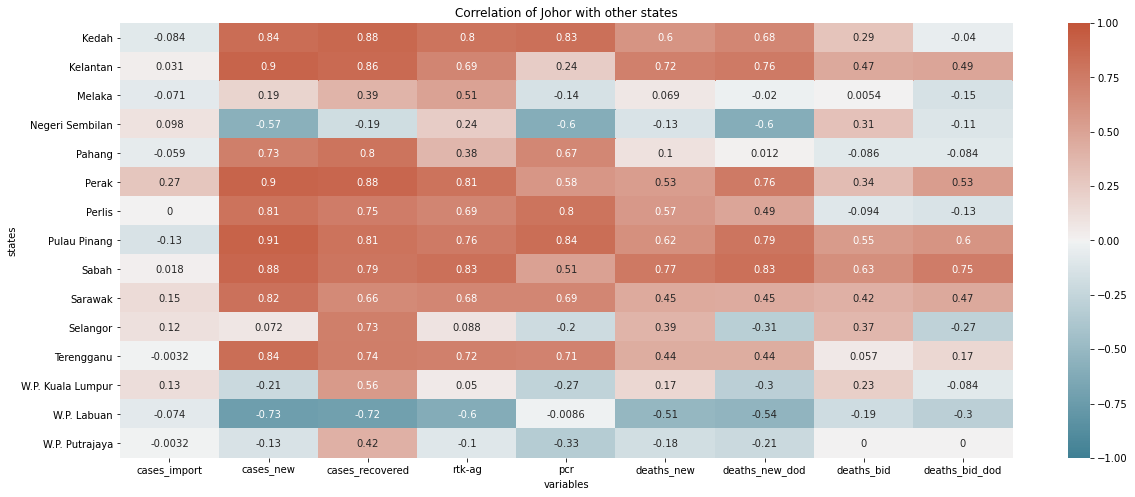

In [61]:
show_correlation_among_states('Johor')

In [62]:
# selects a target state and compare with other states

def check_correlation(df, column, target_state, plot=False):
    
    target_df = df[df['state'] == target_state].copy()
    target_df.reset_index(inplace=True, drop=True)
    
    state_list = df['state'].unique()
    for state in state_list:
        if state == target_state:
            continue
        
        temp_df = df[df['state'] == state].copy()
        temp_df.reset_index(inplace=True, drop=True)
        
        print(target_state, '&', state, target_df[column].corr(temp_df[column]))
        
        if plot: # plots scatterplot
            plt.scatter(target_df[column], temp_df[column])
            plt.xlabel(target_state)
            plt.ylabel(state)
            plt.show()

In [63]:
numeric_columns = df_cases_tests_deaths.describe().columns
print('Pahang')
for col in numeric_columns:
    print('=============', col, '=============')
    check_correlation(df_cases_tests_deaths, col, 'Pahang')
    print()

Pahang
============= cases_import =============
Pahang & Johor -0.059037128341257565
Pahang & Kedah -0.03619531568818805
Pahang & Kelantan -0.004034909337775891
Pahang & Melaka -0.044659623076307116
Pahang & Negeri Sembilan 0.0581966534222523
Pahang & Perak -0.01756068310824982
Pahang & Perlis nan
Pahang & Pulau Pinang -0.0654949403586052
Pahang & Sabah -0.05853561036083277
Pahang & Sarawak -0.00549349392501085
Pahang & Selangor 0.05024439509160528
Pahang & Terengganu -0.025407812858691498
Pahang & W.P. Kuala Lumpur 0.030845949342709775
Pahang & W.P. Labuan 0.25200687358121676
Pahang & W.P. Putrajaya -0.02540781285869155

============= cases_new =============
Pahang & Johor 0.7333801657290339
Pahang & Kedah 0.8019582679482035
Pahang & Kelantan 0.7908860493179672
Pahang & Melaka 0.43167787391318213
Pahang & Negeri Sembilan -0.3026355424434143
Pahang & Perak 0.7377314523456481
Pahang & Perlis 0.5423632282951459
Pahang & Pulau Pinang 0.7070797555233814
Pahang & Sabah 0.6927492886328731
Pa

In [64]:
print('Johor')
for col in numeric_columns:
    print('=============', col, '=============')
    check_correlation(df_cases_tests_deaths, col, 'Pahang')
    print()

Johor
============= cases_import =============
Pahang & Johor -0.059037128341257565
Pahang & Kedah -0.03619531568818805
Pahang & Kelantan -0.004034909337775891
Pahang & Melaka -0.044659623076307116
Pahang & Negeri Sembilan 0.0581966534222523
Pahang & Perak -0.01756068310824982
Pahang & Perlis nan
Pahang & Pulau Pinang -0.0654949403586052
Pahang & Sabah -0.05853561036083277
Pahang & Sarawak -0.00549349392501085
Pahang & Selangor 0.05024439509160528
Pahang & Terengganu -0.025407812858691498
Pahang & W.P. Kuala Lumpur 0.030845949342709775
Pahang & W.P. Labuan 0.25200687358121676
Pahang & W.P. Putrajaya -0.02540781285869155

============= cases_new =============
Pahang & Johor 0.7333801657290339
Pahang & Kedah 0.8019582679482035
Pahang & Kelantan 0.7908860493179672
Pahang & Melaka 0.43167787391318213
Pahang & Negeri Sembilan -0.3026355424434143
Pahang & Perak 0.7377314523456481
Pahang & Perlis 0.5423632282951459
Pahang & Pulau Pinang 0.7070797555233814
Pahang & Sabah 0.6927492886328731
Pah

### 3.2 Correlation within a state

#### 3.2.1 Heatmaps

Text(0.5, 1.0, 'Malaysia')

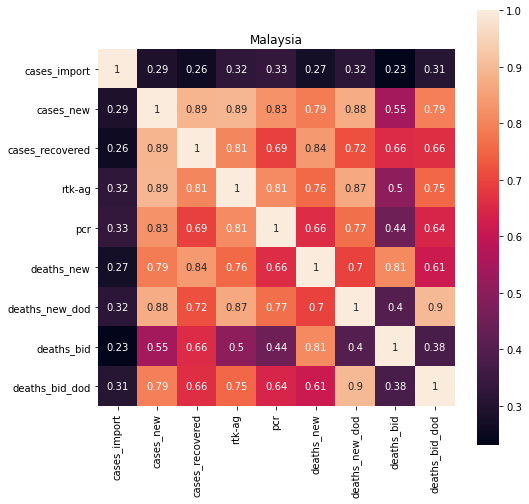

In [65]:
corr_msia = df_cases_tests_deaths.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_msia,square=True,annot=True)
plt.title('Malaysia')

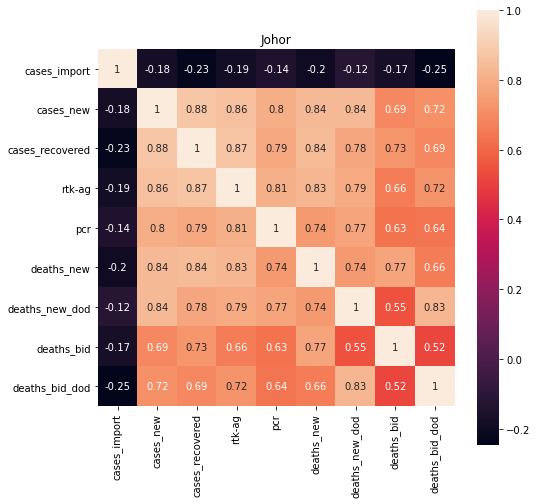

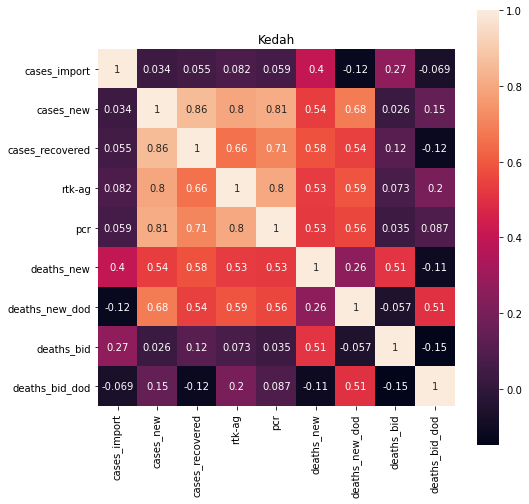

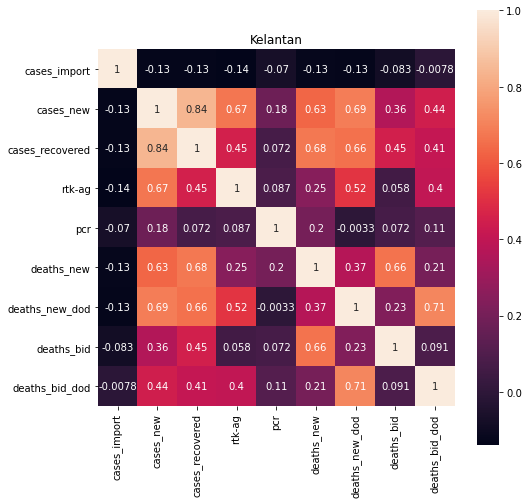

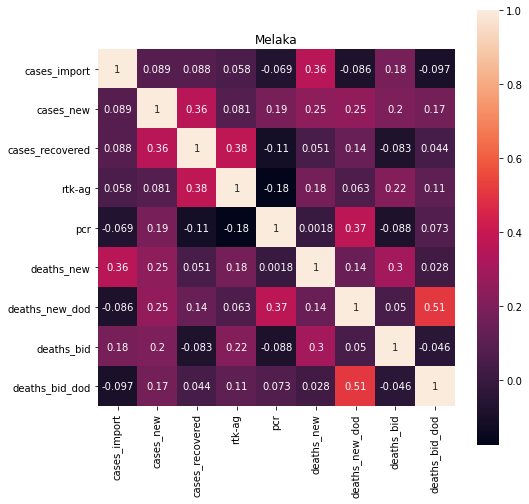

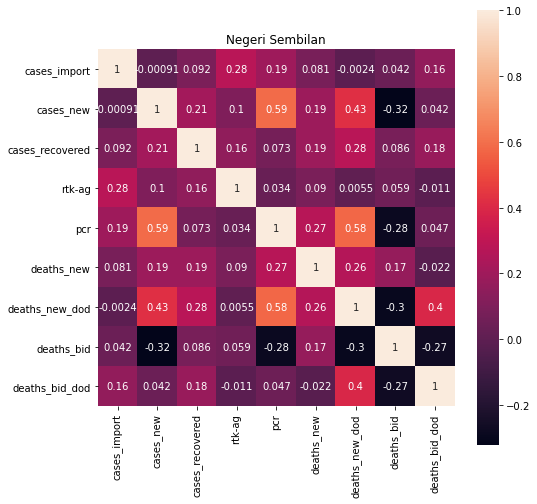

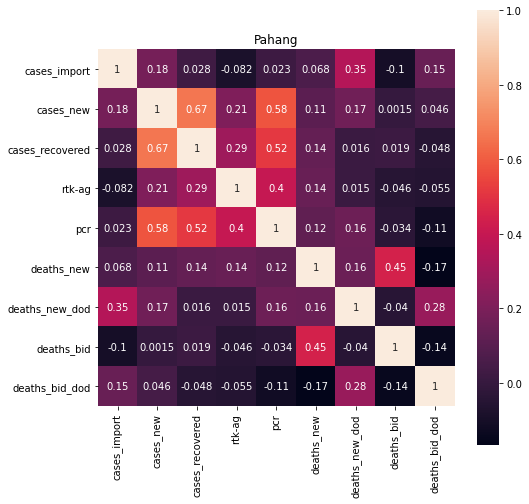

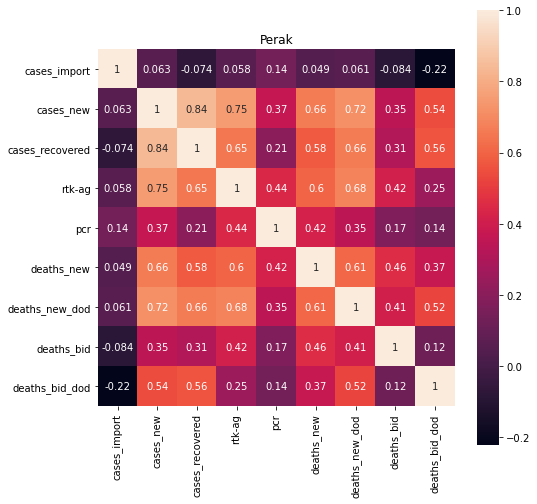

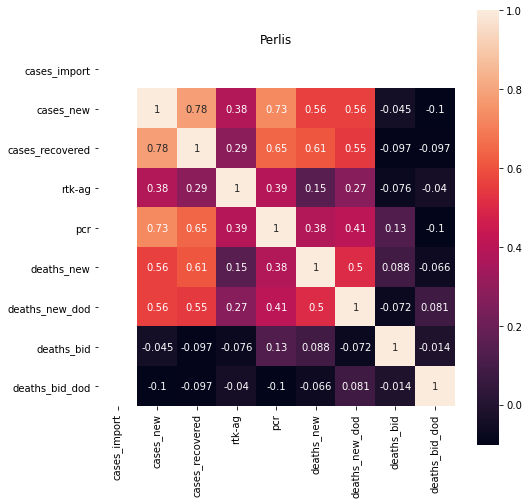

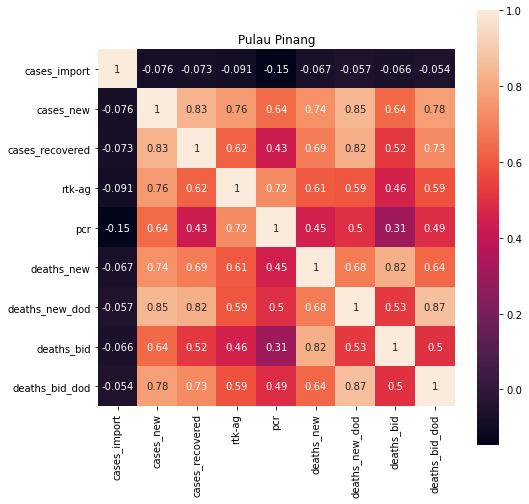

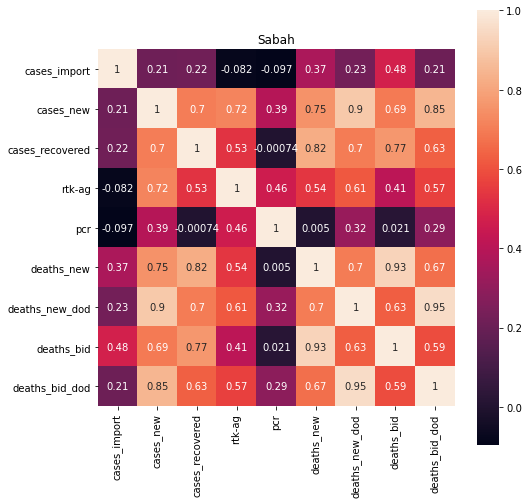

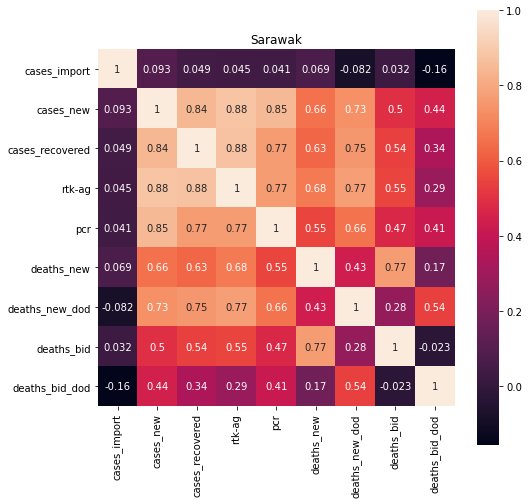

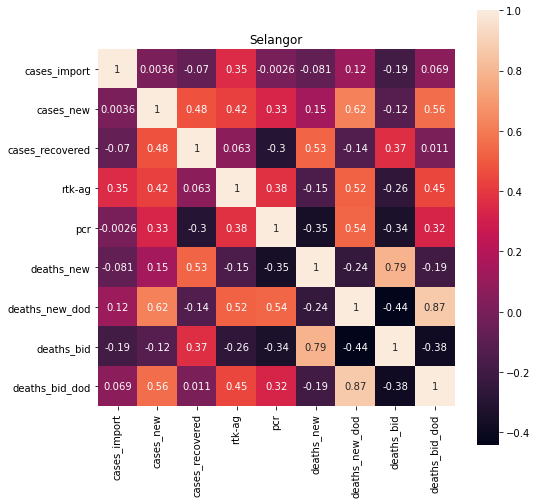

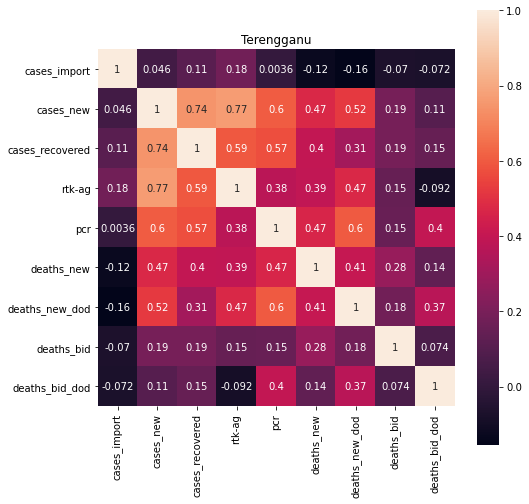

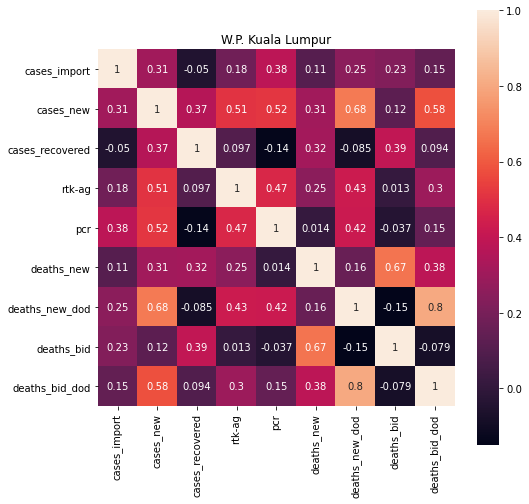

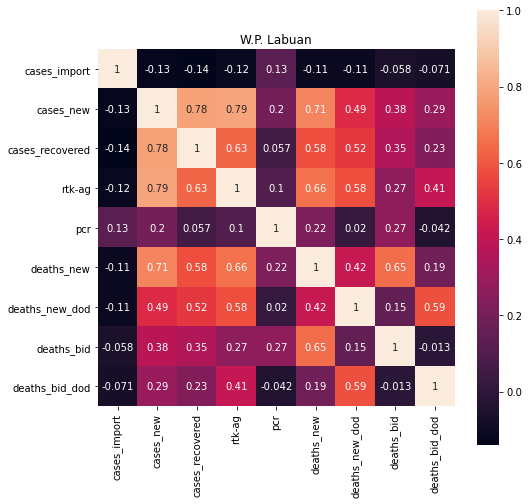

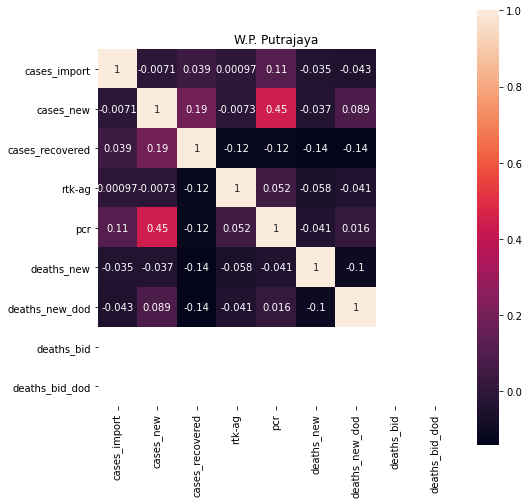

In [66]:
# plot heatmap of all states
for state in states:
    df_state = df_cases_tests_deaths[df_cases_tests_deaths['state'] == state].copy()
    corr_state = df_state.corr()
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr_state,square=True,annot=True)
    plt.title(state)
    plt.show()

Upon checking the heatmap of each states, we noticed that **Perlis** and **W.P.Putrajaya** have interesting patterns

In [67]:
df_perlis = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'Perlis'].copy()
df_perlis.describe()

,cases_import,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod
count,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.0,26.742857,14.885714,169.328571,94.014286,0.428571,0.471429,0.014286,0.014286
std,0.0,29.115306,18.620188,92.956078,67.521439,0.790733,0.793478,0.119523,0.119523
min,0.0,0.000000,0.000000,11.000000,13.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,2.250000,1.000000,104.000000,38.500000,0.000000,0.000000,0.000000,0.000000
50%,0.0,12.000000,5.000000,160.500000,76.500000,0.000000,0.000000,0.000000,0.000000
75%,0.0,48.500000,26.250000,214.000000,148.250000,1.000000,1.000000,0.000000,0.000000
max,0.0,99.000000,79.000000,426.000000,255.000000,3.000000,3.000000,1.000000,1.000000


In [68]:
df_putrajaya = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'W.P. Putrajaya'].copy()
df_putrajaya.describe()

,cases_import,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.0,70.0
mean,0.014286,47.500000,42.657143,265.200000,329.600000,0.128571,0.114286,0.0,0.0
std,0.119523,25.458548,29.293560,726.451981,154.847414,0.447907,0.320455,0.0,0.0
min,0.000000,10.000000,2.000000,9.000000,103.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,26.000000,19.000000,83.250000,212.500000,0.000000,0.000000,0.0,0.0
50%,0.000000,44.000000,42.000000,184.500000,316.500000,0.000000,0.000000,0.0,0.0
75%,0.000000,56.000000,58.500000,243.250000,402.250000,0.000000,0.000000,0.0,0.0
max,1.000000,122.000000,123.000000,6195.000000,757.000000,2.000000,1.000000,0.0,0.0


According to our data, **Perlis** has 0 `cases_import` in total and **W.P. Putrajaya** has 0 `deaths_bid` and `deaths_bid_dod`. This causes the strange patterns in their heatmaps.

##### 3.1.1 Pahang, Kedah, Johor and Selangor

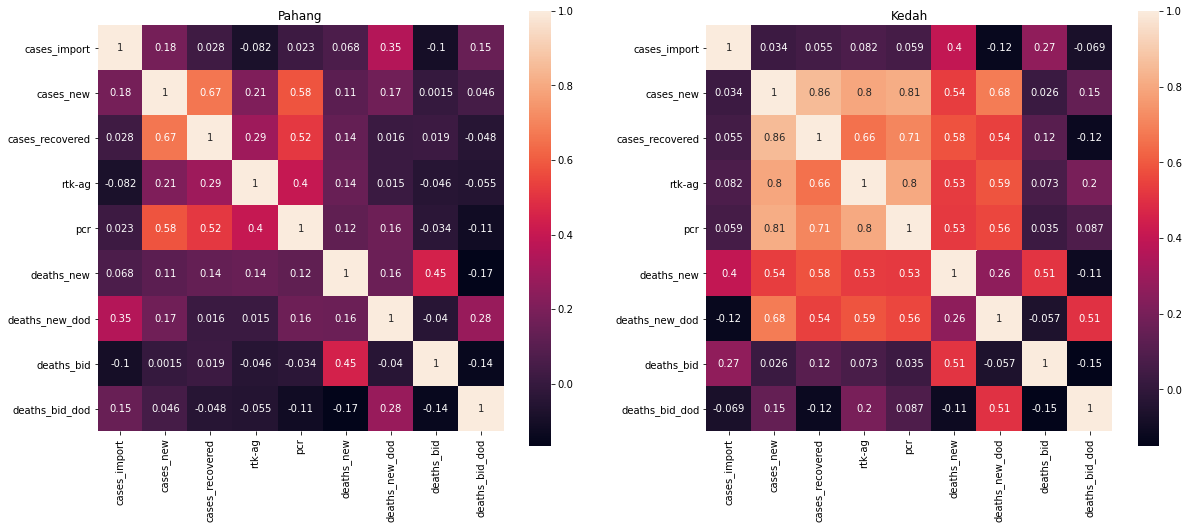

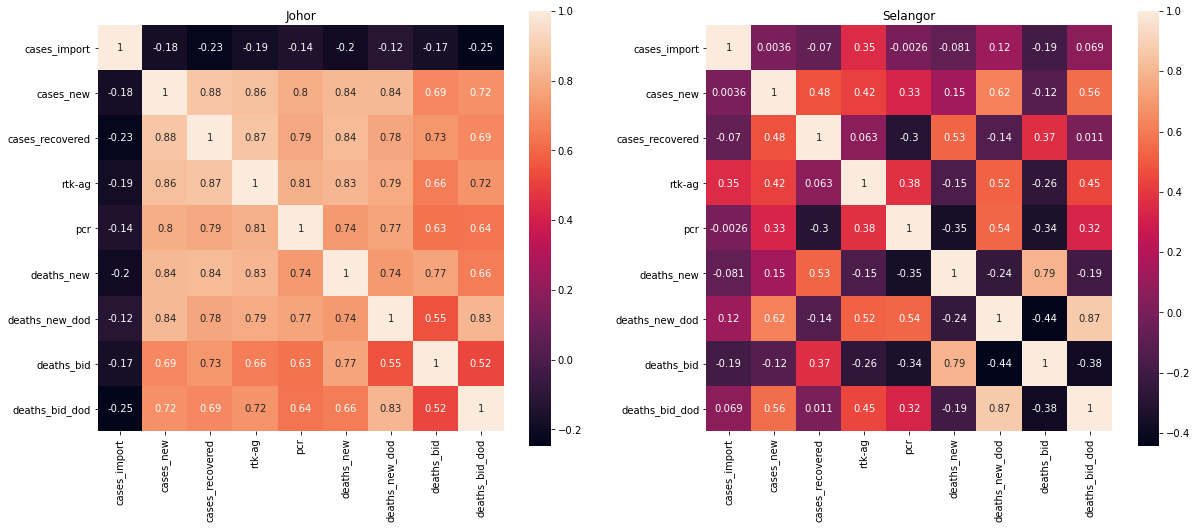

In [69]:
states = ['Pahang', 'Kedah', 'Johor', 'Selangor']
corr = {}

for state in states:
    df_state = df_cases_tests_deaths[df_cases_tests_deaths['state'] == state].copy()
    corr[state] = df_state.corr()
    
plt.figure(figsize=(20, 8))
plt.subplot(121)
sns.heatmap(corr['Pahang'],square=True,annot=True)
plt.title('Pahang')
plt.subplot(122)
sns.heatmap(corr['Kedah'],square=True,annot=True)
plt.title('Kedah')
plt.show()

plt.figure(figsize=(20, 8))
plt.subplot(121)
sns.heatmap(corr['Johor'],square=True,annot=True)
plt.title('Johor')
plt.subplot(122)
sns.heatmap(corr['Selangor'],square=True,annot=True)
plt.title('Selangor')
plt.show()

#### 3.2.2 Feature Importance

Calculating the feature importance score for the regression and classification later.

In [70]:
# checking feature importance using Decision Tree and Random Forest
def feature_importance(X, y, state=""):
    
    # Decision Tree
    model = DecisionTreeRegressor(criterion='mse', splitter='random')
    model.fit(X, y)
    importance = model.feature_importances_
    
    print(f'Decision Tree Regression Feature Importance for {state}\n')
    for i, col in enumerate(X.columns):
        print(col, importance[i])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    shap.summary_plot(shap_values, X, plot_type="bar")
    
    
    # Random Forest
    model = RandomForestRegressor(max_depth=7, random_state=0)
    model.fit(X, np.ravel(y))
    importance = model.feature_importances_

    print(f'Random Forest Regression Feature Importance for {state}\n')
    for i, col in enumerate(X.columns):
        print(col, importance[i])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    shap.summary_plot(shap_values, X, plot_type='bar')

##### 3.2.2.1 Pahang

Investigating the strong indicators to the daily cases in **Pahang**.

Decision Tree Regression Feature Importance for Pahang

cases_import 0.03843111434428025
cases_recovered 0.5479614719775066
deaths_bid 0.053796365775178
deaths_bid_dod 0.018867148827700433
deaths_new 0.08760202124575896
deaths_new_dod 0.03654817425286557
pcr 0.132990001592268
rtk-ag 0.08380370198444209


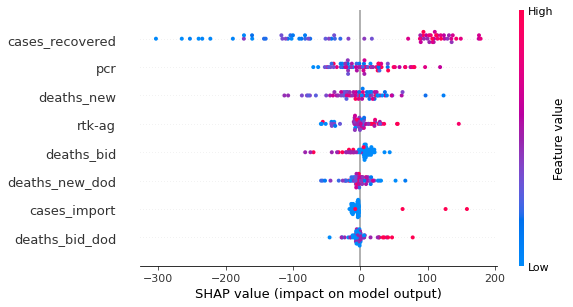

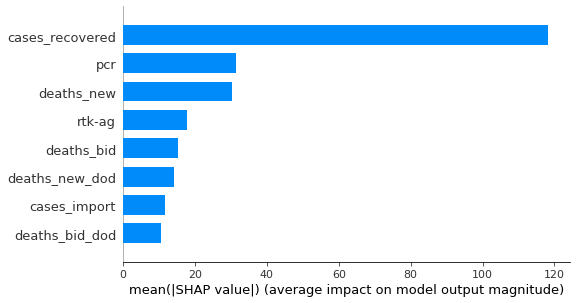

Random Forest Regression Feature Importance for Pahang

cases_import 0.01723921010897433
cases_recovered 0.6276390087273518
deaths_bid 0.015491471589392309
deaths_bid_dod 0.010938141951370915
deaths_new 0.03467304155907633
deaths_new_dod 0.04830340135894632
pcr 0.11529903225639324
rtk-ag 0.13041669244849488


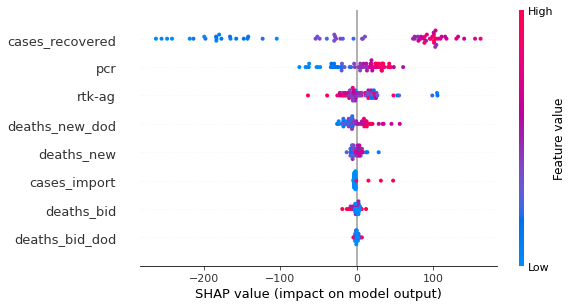

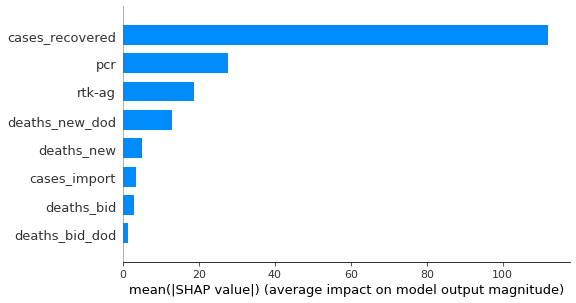

In [71]:
df_pahang = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'Pahang'].copy()
df_pahang.drop(['date', 'state'], axis=1, inplace=True)
df_pahang.reset_index(inplace=True, drop=True)

X = df_pahang.loc[:, df_pahang.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_pahang[['cases_new']]

feature_importance(X, y, state='Pahang')

From the result above, it is shown that the feature importance for Decision Tree and Random Forest Regression are the almost same. The strongest feature to Pahang's daily cases is `cases_recovered`, followed by `pcr` and `rtk-ag`.

##### 3.2.2.2 Kedah

Investigating the strong indicators to the daily cases in **Kedah**.

Decision Tree Regression Feature Importance for Kedah

cases_import 0.002904485201769367
cases_recovered 0.1073855793776278
deaths_bid 0.005931000847176673
deaths_bid_dod 0.010364195396919686
deaths_new 0.0060535288328738045
deaths_new_dod 0.0906883078547019
pcr 0.5074460944854694
rtk-ag 0.26922680800346144


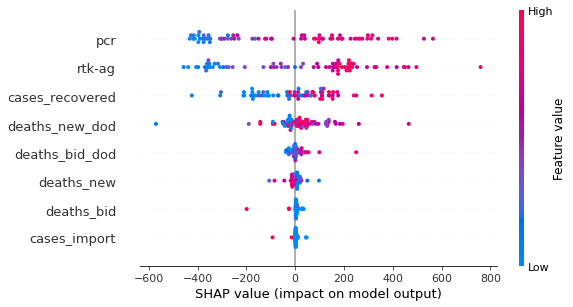

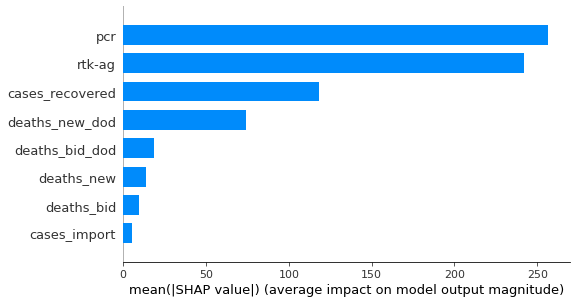

Random Forest Regression Feature Importance for Kedah

cases_import 7.081645824801608e-05
cases_recovered 0.7551162305892843
deaths_bid 0.0010360153993133603
deaths_bid_dod 0.011088899076453308
deaths_new 0.030544648480122102
deaths_new_dod 0.05196528770787843
pcr 0.04930299217059195
rtk-ag 0.10087511011810854


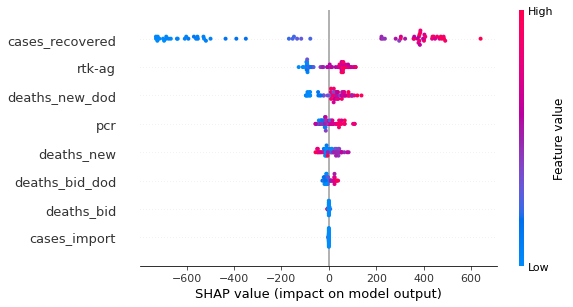

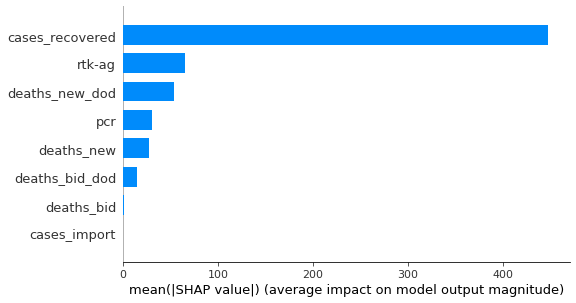

In [72]:
df_kedah = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'Kedah'].copy()
df_kedah.drop(['date', 'state'], axis=1, inplace=True)
df_kedah.reset_index(inplace=True, drop=True)

X = df_kedah.loc[:, df_kedah.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_kedah[['cases_new']]

feature_importance(X, y, state='Kedah')

Kedah has only one strong feature for its daily cases, which is `cases_recovered`.

##### 3.2.2.3 Johor

Investigating the strong indicators to the daily cases in **Johor**.

Decision Tree Regression Feature Importance for Johor

cases_import 0.0013129376889309589
cases_recovered 0.049750672596981266
deaths_bid 0.016003589571103236
deaths_bid_dod 0.011371094132000539
deaths_new 0.1503848907645633
deaths_new_dod 0.6488778710005848
pcr 0.08404527863259811
rtk-ag 0.03825366561323777


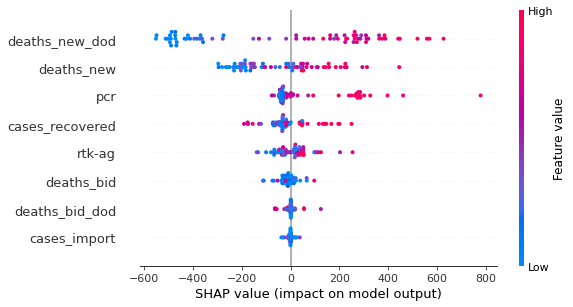

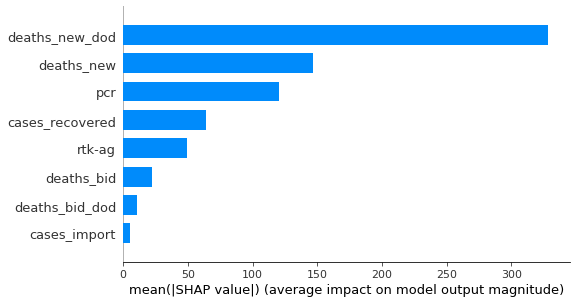

Random Forest Regression Feature Importance for Johor

cases_import 0.0026314469176732425
cases_recovered 0.24305102322241612
deaths_bid 0.026321666662441533
deaths_bid_dod 0.025996740667788076
deaths_new 0.10272266630182862
deaths_new_dod 0.2742556347774977
pcr 0.0948067529687426
rtk-ag 0.2302140684816121


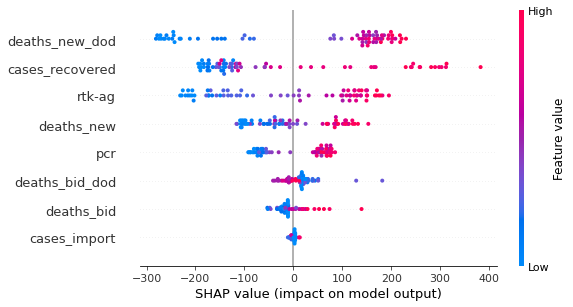

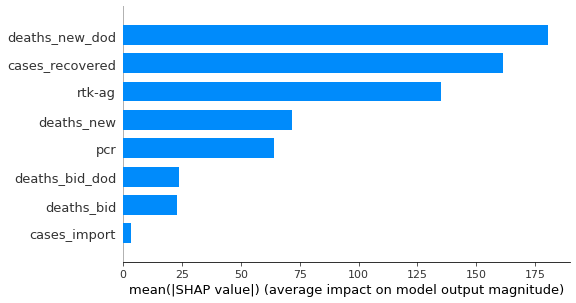

In [73]:
df_johor = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'Johor'].copy()
df_johor.drop(['date', 'state'], axis=1, inplace=True)
df_johor.reset_index(inplace=True, drop=True)

X = df_johor.loc[:, df_johor.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_johor[['cases_new']]

feature_importance(X, y, state='Johor')

Unlike Pahang, Johor has a different set of features affecting its daily cases. Using a Decision Tree Regressor, it is shown that the top 3 features are `deaths_new`, `cases_recovered` and `rtk-ag`.

On the other hand, while using a Random Forest Regressor, the top 3 features are `deaths_new_dod`, `cases_recovered`, `rtk-ag`.

##### 3.2.2.4 Selangor

Investigating the strong indicators to the daily cases in **Selangor**.

Decision Tree Regression Feature Importance for Selangor

cases_import 0.017800409796044192
cases_recovered 0.2569741117140947
deaths_bid 0.059397781252363405
deaths_bid_dod 0.28628591061764097
deaths_new 0.06082990226029127
deaths_new_dod 0.10419786236674732
pcr 0.19322908481219855
rtk-ag 0.02128493718061962


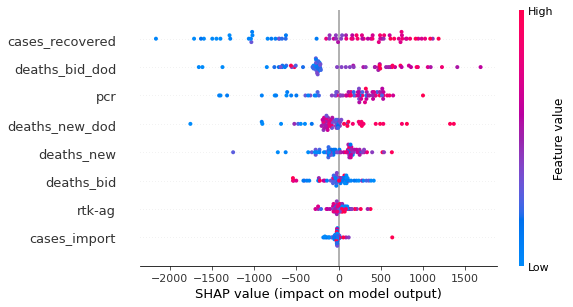

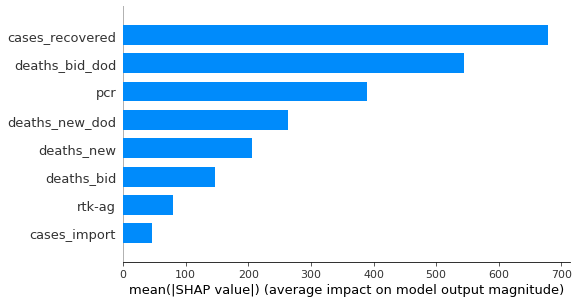

Random Forest Regression Feature Importance for Selangor

cases_import 0.015008221072619217
cases_recovered 0.2985571519905454
deaths_bid 0.02338748881150938
deaths_bid_dod 0.15667795778602508
deaths_new 0.05389411924171667
deaths_new_dod 0.34830486533896327
pcr 0.06235003696542771
rtk-ag 0.041820158793193396


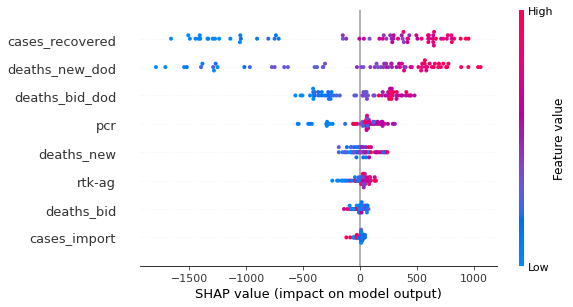

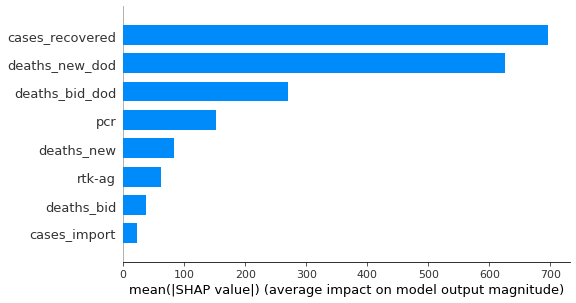

In [74]:
df_selangor = df_cases_tests_deaths[df_cases_tests_deaths['state'] == 'Selangor'].copy()
df_selangor.drop(['date', 'state'], axis=1, inplace=True)
df_selangor.reset_index(inplace=True, drop=True)

X = df_selangor.loc[:, df_selangor.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_selangor[['cases_new']]

feature_importance(X, y, state='Selangor')

For Selangor, the Decision Tree Regressor shows the top features for its daily cases are `cases_recovered`, `deaths_new_dod`. The results are also the same from Random Forest Regressor.

## 4. Building Prediction Models

Select specific data from specific states ('Pahang', 'Kedah', 'Johor', 'Selangor') for building regression and classification models.

In [75]:
df_predict = df_cases_tests_deaths.copy()

df_predict = df_predict.loc[(df_predict['state']=='Pahang') | (df_predict['state'] == 'Kedah') |
                            (df_predict['state'] == 'Johor') | (df_predict['state'] == 'Selangor'), :]

df_predict.drop(['date', 'state'], axis=1, inplace=True)
df_predict

,cases_import,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod,cases_new_binned
0,1,270,361.0,2749,3670,6,8,0,2,High
1,0,250,186.0,2073,1297,0,3,0,0,High
5,0,195,19.0,2103,2605,2,5,0,1,High
11,2,2885,1829.0,13805,16460,46,39,6,5,High
16,0,517,584.0,2455,4428,4,4,0,0,High
...,...,...,...,...,...,...,...,...,...,...
1099,2,2407,4645.0,22944,14261,56,7,38,0,High
1104,0,1867,1789.0,12220,10283,64,22,18,5,High
1105,1,1564,1912.0,5018,3594,52,7,11,0,High
1109,0,700,409.0,2296,5143,4,4,0,0,High


Text(0.5, 1.0, 'Pahang, Kedah, Johor, Selangor')

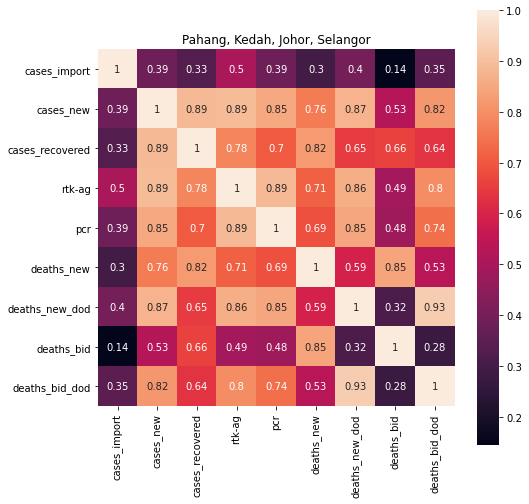

In [76]:
corr_predict = df_predict.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_predict,square=True,annot=True)
plt.title('Pahang, Kedah, Johor, Selangor')

`cases_import` and `deaths_bid` does not seems to help in predicting `cases_new`, hence it was dropped.

In [77]:
df_predict.drop(['cases_import'], axis=1, inplace=True)
df_predict

,cases_new,cases_recovered,rtk-ag,pcr,deaths_new,deaths_new_dod,deaths_bid,deaths_bid_dod,cases_new_binned
0,270,361.0,2749,3670,6,8,0,2,High
1,250,186.0,2073,1297,0,3,0,0,High
5,195,19.0,2103,2605,2,5,0,1,High
11,2885,1829.0,13805,16460,46,39,6,5,High
16,517,584.0,2455,4428,4,4,0,0,High
...,...,...,...,...,...,...,...,...,...
1099,2407,4645.0,22944,14261,56,7,38,0,High
1104,1867,1789.0,12220,10283,64,22,18,5,High
1105,1564,1912.0,5018,3594,52,7,11,0,High
1109,700,409.0,2296,5143,4,4,0,0,High


### 4.1 Regression Models

Regression models that will be used:
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. Support Vector Regressor

Evaluation matrics that will be used:
1. R Square
2. Mean Absolute Error(MAE)
3. Root Mean Square Error(RMSE)

In [78]:
X = df_predict.loc[:, df_predict.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_predict[['cases_new']]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### 4.1.1 Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [80]:
reg_l = LinearRegression()

reg_l = reg_l.fit(X_train, y_train)

y_pred = reg_l.predict(X_test)

In [81]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.91355
Mean Absolute Error(MAE)    : 366.46956
Root Mean Square Error(RMSE): 533.95922


#### 4.1.2 Decision Tree Regressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [82]:
reg_dt = DecisionTreeRegressor(criterion='mse', splitter='random')

reg_dt = reg_dt.fit(X_train, y_train)

y_pred = reg_dt.predict(X_test)

In [83]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.77019
Mean Absolute Error(MAE)    : 487.73214
Root Mean Square Error(RMSE): 870.56282


#### 4.1.3 Random Forest Regressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [84]:
reg_rf = RandomForestRegressor(max_depth=7, random_state=0)

reg_rf = reg_rf.fit(X_train, np.ravel(y_train))

y_pred = reg_rf.predict(X_test)

In [85]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.93570
Mean Absolute Error(MAE)    : 300.95153
Root Mean Square Error(RMSE): 460.48208


#### 4.1.4 Support Vector Regressor

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [86]:
reg_sv = SVR(kernel='linear')

reg_sv = reg_sv.fit(X_train, np.ravel(y_train))

y_pred = reg_sv.predict(X_test)

In [87]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.92911
Mean Absolute Error(MAE)    : 323.42266
Root Mean Square Error(RMSE): 483.50416


#### 4.1.5 Regression Model Evaluation

From the results above,

|                               | Linear Regression | Decision Tree | Random Forest | SVR       |
| ----------------------------- | ----------------- | ------------- | ------------- | --------- |
| R Square                      | 0.91355           | 0.94883       | 0.93570       | 0.92911   |
| Mean Absolute Error (MAE)     | 366.46956         | 307.41071     | 300.95153     | 323.42266 |
| Root Mean Square Error (RMSE) | 533.95922         | 410.80468     | 460.48208     | 483.50416 |


R Square values ranges from 0 to 1. The higher value of R Square indicates that the model fits the data better. On the other hand, both MAE and RMSE ranges from 0 to $\infty$, and lower values are preferred.

In our case, the R Square values of all 4 regressor are very close to 1. However, their MAE and RMSE are very high. We would consider Decision Tree and Random Forest as better regressors in this case as their R Square is higher and the errors are relatively lower than others.

We tried dropping `deaths_bid` but the performance went down.

### 4.2 Classification Models

Classification models that will be used:
1. K-Nearest Neighbors Classifier
2. Naive Bayes Classifier
3. Decision Tree Classifier
4. Random Forest Classifier

Performance evaluation metrics that will be used:
1. Confusion Matrix
2. Precision, Recall, F1-score
3. ROC Curve

We binned the daily new cases into 3 categories.

High        216
Moderate     33
Low          31
Name: cases_new_binned, dtype: int64


Text(0, 0.5, 'Frequency')

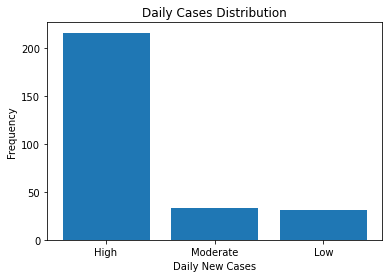

In [88]:
print(df_predict['cases_new_binned'].value_counts())

plt.bar(df_predict['cases_new_binned'].value_counts().index, 
        df_predict['cases_new_binned'].value_counts())

plt.title('Daily Cases Distribution')
plt.xlabel('Daily New Cases')
plt.ylabel('Frequency')

However, the results shows that the data is highly imbalanced.

In [89]:
# encoding
encode = {"High": 0, "Moderate": 1, "Low": 2}

df_predict_2 = df_predict.copy()
df_predict_2['cases_new_binned'] = df_predict_2['cases_new_binned'].map(encode)

In [90]:
X = df_predict_2.loc[:, df_predict_2.columns.difference(['cases_new', 'cases_new_binned'])]
y = df_predict_2[['cases_new_binned']]

print(X.shape)
print(y.shape)

(280, 7)
(280, 1)


Applying **SMOTE** to balance the <span style=color:red>**training dataset**</span>.

SMOTE helps oversample minority classes in our data. In our case, `low` and `moderate` the minorities in `cases_new_binned`. We will apply SMOTE to our training data before fitting into a model. This helps balance the class distribution during the training but not giving any additional information. SMOTE should only be applied to the training dataset (not testing/validation set).

If SMOTE is implemented prior to the train-test splitting, some of the synthetic data might end up in the testing/validation set, allowing the model to perform well at the moment. However, the model will underperform in production as it overfits to most of our synthetic data

References:   
[SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/#:~:text=This%20can%20be%20achieved%20by%20simply%20duplicating%20examples%20from%20the%20minority%20class%20in%20the%20training%20dataset%20prior%20to%20fitting%20a%20model.%20This%20can%20balance%20the%20class%20distribution%20but%20does%20not%20provide%20any%20additional%20information%20to%20the%20model.)  
[SMOTE](https://www.youtube.com/watch?v=IwyIKRz2v2o)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [92]:
print("--Before--")
counter = Counter(y_train['cases_new_binned'])
print(counter)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("--After--")
counter = Counter(y_train['cases_new_binned'])
print(counter)

print()
print(X_train.shape)
print(y_train.shape)

--Before--
Counter({0: 171, 2: 27, 1: 26})
--After--
Counter({1: 171, 0: 171, 2: 171})

(513, 7)
(513, 1)


In [93]:
y_train.cases_new_binned.value_counts()

0    171
1    171
2    171
Name: cases_new_binned, dtype: int64

#### 4.2.1 K-Nearest Neighbors (KNN) Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [94]:
clf_KNN = KNeighborsClassifier(n_neighbors=3)

clf_KNN = clf_KNN.fit(X_train, np.ravel(y_train))

y_pred = clf_KNN.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_KNN.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_KNN.score(X_test, y_test))) # accuracy score

Accuracy on training set: 0.97076
Accuracy on test set:     0.92857


In [95]:
# save all y_pred in a dict
model_y_pred = {}
model_y_pred['KNN'] = y_pred

#### 4.2.2 Naïve Bayes Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [96]:
clf_NB = GaussianNB()

clf_NB = clf_NB.fit(X_train, np.ravel(y_train))

y_pred = clf_NB.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_NB.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_NB.score(X_test, y_test)))

model_y_pred['Naive Bayes'] = y_pred

Accuracy on training set: 0.89474
Accuracy on test set:     0.83929


#### 4.2.3 Decision Tree Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [97]:
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=7, splitter='best')

clf_DT = clf_DT.fit(X_train, y_train)

y_pred = clf_DT.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_DT.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_DT.score(X_test, y_test)))

model_y_pred['Decision Tree'] = y_pred

Accuracy on training set: 0.99025
Accuracy on test set:     0.87500


#### 4.2.4 Random Forest Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [98]:
clf_RF = RandomForestClassifier(max_depth=10, random_state=0)

clf_RF = clf_RF.fit(X_train, np.ravel(y_train))

y_pred = clf_RF.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_RF.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_RF.score(X_test, y_test)))

model_y_pred['Random Forest'] = y_pred

Accuracy on training set: 1.00000
Accuracy on test set:     0.94643


#### 4.2.5 Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [99]:
clf_SV = SVC(kernel='linear', probability=True)

clf_SV = clf_SV.fit(X_train, np.ravel(y_train))

y_pred = clf_SV.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_SV.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_SV.score(X_test, y_test)))

model_y_pred['SVC'] = y_pred

Accuracy on training set: 0.95517
Accuracy on test set:     0.91071


#### 4.2.6 Classification Model Evaluation

To evaluate the performance of each classifier, we plot the confusion matrix for each of them.

In [100]:
def get_confusion_matrix(y_pred, name=""):
    cm = confusion_matrix(y_test, y_pred)
    
    ax = sns.heatmap(cm,annot=True, cmap='Greens')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f"{name} Confusion Matrix")
    
    return ax

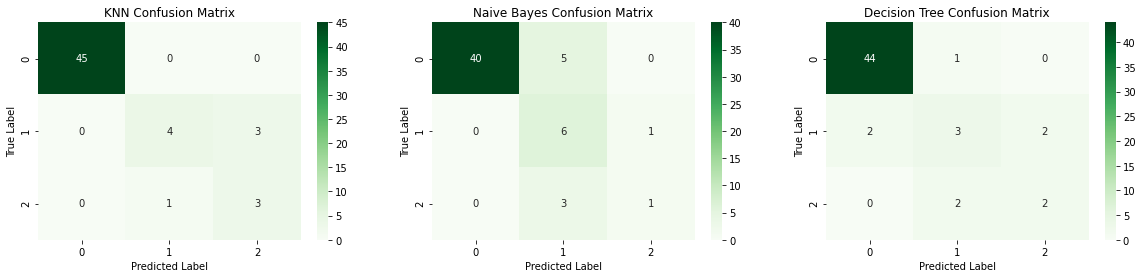

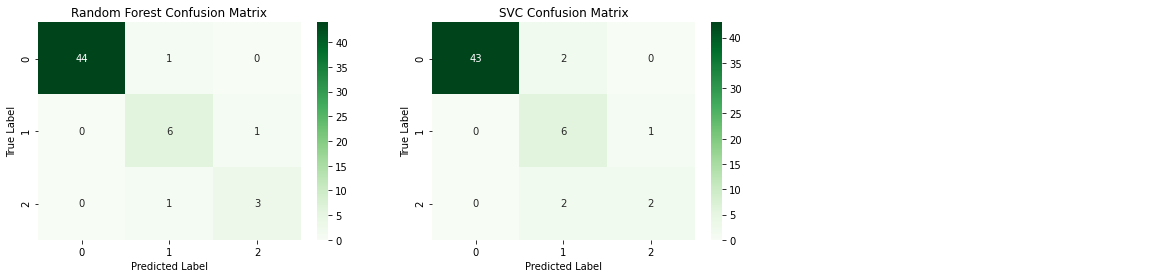

In [101]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_confusion_matrix(model_y_pred.get("KNN"), name="KNN")

plt.subplot(1, 3, 2)
get_confusion_matrix(model_y_pred.get("Naive Bayes"), name="Naive Bayes")

plt.subplot(1, 3, 3)
get_confusion_matrix(model_y_pred.get("Decision Tree"), name="Decision Tree")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_confusion_matrix(model_y_pred.get("Random Forest"), name="Random Forest")

plt.subplot(1, 3, 2)
get_confusion_matrix(model_y_pred.get("SVC"), name="SVC")

plt.subplot(1, 3, 3)
plt.xticks([]), plt.yticks([])
plt.axis("off")

plt.show()

Next, we will generate a classification report for each model. Each report shows the score for all classification metrics (Precision, Recall, F1-score) on the class basis.

In [102]:
def get_classification_report(y_pred, name=""):
    # calculate precision, recall, f1 for each class
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    report = np.flipud(np.rot90([precision, recall, f1]))
    ax = sns.heatmap(report,annot=True, cmap='RdBu', vmin=0, vmax=1)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Classes')
    ax.set_xticklabels(['Precision', 'Recall', 'F1-score'])
    ax.set_title(f"{name} Classification Report")
    
    return ax

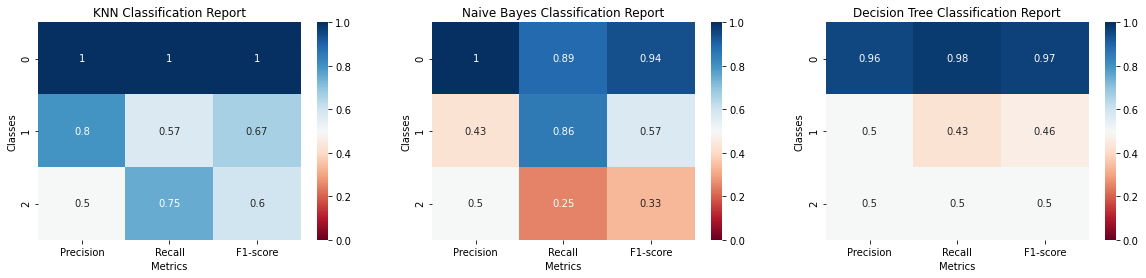

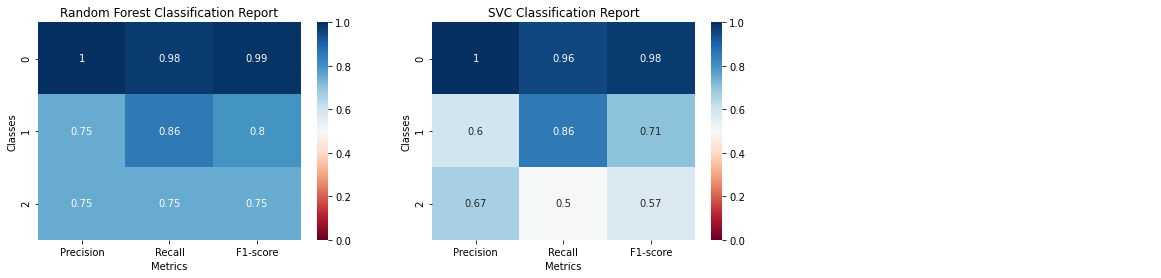

In [103]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_classification_report(model_y_pred.get("KNN"), name="KNN")

plt.subplot(1, 3, 2)
get_classification_report(model_y_pred.get("Naive Bayes"), name="Naive Bayes")

plt.subplot(1, 3, 3)
get_classification_report(model_y_pred.get("Decision Tree"), name="Decision Tree")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_classification_report(model_y_pred.get("Random Forest"), name="Random Forest")

plt.subplot(1, 3, 2)
get_classification_report(model_y_pred.get("SVC"), name="SVC")

plt.subplot(1, 3, 3)
plt.xticks([]), plt.yticks([])
plt.axis("off")

plt.show()

Last but not least, we plotted the ROC curve for each of the classifier and calcualted the area under the curve.

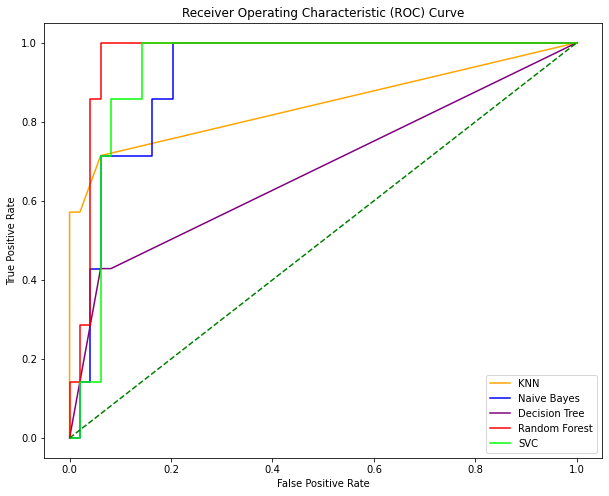

In [104]:
prob_KNN = clf_KNN.predict_proba(X_test)[:,1]
prob_NB = clf_NB.predict_proba(X_test)[:,1]
prob_DT = clf_DT.predict_proba(X_test)[:,1]
prob_RF = clf_RF.predict_proba(X_test)[:,1]
prob_SV = clf_SV.predict_proba(X_test)[:,1]

proba = [prob_KNN, prob_NB, prob_DT, prob_RF, prob_SV]
color = ['orange', 'blue', 'purple', 'red', 'lime']
label = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'SVC']


plt.figure(figsize=(10, 8))
for i in range(len(proba)):
    fpr, tpr, thresholds = roc_curve(y_test, proba[i], pos_label=1)
    plt.plot(fpr, tpr, color=color[i], label=label[i]) 
    
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()


It is shown that our best model for classifying the daily cases for Pahang, Kedah, Johor and Selangor is the Random Forest Classifier, following up by KNN and Decision Tree. The Naive Bayes Classifier performs the poorest in this case.

## References

[How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/#:~:text=Feature%20importance%20refers%20to%20techniques,at%20predicting%20a%20target%20variable.&text=The%20role%20of%20feature%20importance%20in%20a%20predictive%20modeling%20problem.)

[Feature Selection Techniques in Machine Learning with Python](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

[SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/#:~:text=This%20can%20be%20achieved%20by%20simply%20duplicating%20examples%20from%20the%20minority%20class%20in%20the%20training%20dataset%20prior%20to%20fitting%20a%20model.%20This%20can%20balance%20the%20class%20distribution%20but%20does%20not%20provide%20any%20additional%20information%20to%20the%20model.)  

[SMOTE](https://www.youtube.com/watch?v=IwyIKRz2v2o)

[Evaluating Multi-Class Classifiers](https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b)